This notebook conducts the analyses and generates the figures reported in the accompanying paper:

Lee MR, Hicks JL, Wren TAL, & Delp SL. Independently ambulatory children with spina bifida experience near-typical knee and ankle joint moments and forces during walking. _Gait and Posture_, in press.

Copyright (c) 2022, Stanford Neuromuscular Biomechanics Laboratory
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:
1. Redistributions of source code must retain the above copyright notice, 
this list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright
notice, this list of conditions and the following disclaimer in the 
documentation and/or other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its
contributors may be used to endorse or promote products derived from this
software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS
IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR 
CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, 
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, 
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR
PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF
LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING
NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [1]:
import os
import sys
sys.path.insert(0, os.getcwd() + '\postprocessing_helpers')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D
from scipy.stats import spearmanr

from stats import print_ttest, run_spm, plot_sig
from read_data import get_bone_outcomes, get_analyzed_side_pf_strength
from generate_summary_waveforms import generate_summary_waveforms, average_subject_trials
from plot_emg_comparisons import plot_emg_comparisons
from get_average_walking_speeds import get_average_walking_speeds

# Demographics
Compare age, height, weight, body mass index (BMI), sex, and bone outcomes between the group with typical development (TD) and the group with spina bifida (SB). Note that the children in the group with typical development were age- and sex-matched to the children in the group with spina bifida.

In [3]:
demographics = pd.read_excel('../data/demographics.xlsx', header=1)
emg_demographics = demographics[demographics['subject'].str.contains('E')].copy() # emg secondary cohort
sb_demographics = demographics[demographics['subject'].str.contains('S')].copy() # spina bifida
td_demographics = demographics[demographics['subject'].str.contains('T')].copy() # typical development

In [4]:
# age & size
demographics_to_compare = ['age (years)', 'height (cm)',
                           'weight (kg)', 'bmi (kg/m2)']
    
for demographic_to_compare in demographics_to_compare:
    print_ttest(td_demographics, sb_demographics, 'TD', 'SB', demographic_to_compare)

age (years): 0.893
	TD: 10.6 (2.3)
	SB: 10.4 (2.7)
height (cm): 0.920
	TD: 140.1 (14.3)
	SB: 140.6 (17.7)
weight (kg): 0.939
	TD: 41.2 (17.3)
	SB: 41.7 (21.1)
bmi (kg/m2): 0.868
	TD: 20.2 (5.6)
	SB: 19.9 (5.3)


In [5]:
# female/male
n_td_female = np.sum(td_demographics['sex']=='female')
n_td_male = np.sum(td_demographics['sex']=='male')

n_sb_female = np.sum(sb_demographics['sex']=='female')
n_sb_male = np.sum(sb_demographics['sex']=='male')

print('TD: %iF / %iM' %(n_td_female, n_td_male))
print('SB: %iF / %iM' %(n_sb_female, n_sb_male))

TD: 8F / 8M
SB: 8F / 8M


Age, height, weight, BMI, and sex did not significantly differ between the groups.

In [6]:
# bone strength outcomes
bone_outcome_names = ['proximal cross-sectional area (mm2)',
                      'proximal cancellous bone density (mg/cm3)',
                      'distal cross-sectional area (mm2)',
                      'distal cancellous bone density (mg/cm3)', 
                      'midshaft cortical bone area (mm2)',
                      'midshaft cross-sectional area (mm2)',
                      'midshaft cortical thickness (mm)',
                      'midshaft cortical bone density (mg/cm3)'
                     ]

# get stance-limb-associated bone outcomes
td_bone_outcomes = get_bone_outcomes(td_demographics, bone_outcome_names)
sb_bone_outcomes = get_bone_outcomes(sb_demographics, bone_outcome_names)

for bone_outcome_name in bone_outcome_names:
    print_ttest(td_bone_outcomes, sb_bone_outcomes, 'TD', 'SB', bone_outcome_name)

proximal cross-sectional area (mm2): 0.590
	TD: 847.0 (205.6)
	SB: 897.4 (293.2)
proximal cancellous bone density (mg/cm3): 0.001
	TD: 165.1 (41.1)
	SB: 114.4 (35.6)
distal cross-sectional area (mm2): 0.651
	TD: 647.8 (165.6)
	SB: 618.0 (190.2)
distal cancellous bone density (mg/cm3): 0.258
	TD: 160.6 (39.1)
	SB: 144.9 (35.2)
midshaft cortical bone area (mm2): 0.926
	TD: 229.5 (60.8)
	SB: 226.9 (88.6)
midshaft cross-sectional area (mm2): 0.946
	TD: 293.5 (72.1)
	SB: 295.7 (105.4)
midshaft cortical thickness (mm): 0.656
	TD: 5.1 (0.8)
	SB: 5.0 (1.1)
midshaft cortical bone density (mg/cm3): 0.288
	TD: 1000.6 (48.2)
	SB: 1022.3 (60.5)


Only cancellous bone density in the proximal tibia is significantly different between the two groups.

# Musculoskeletal simulation evaluation

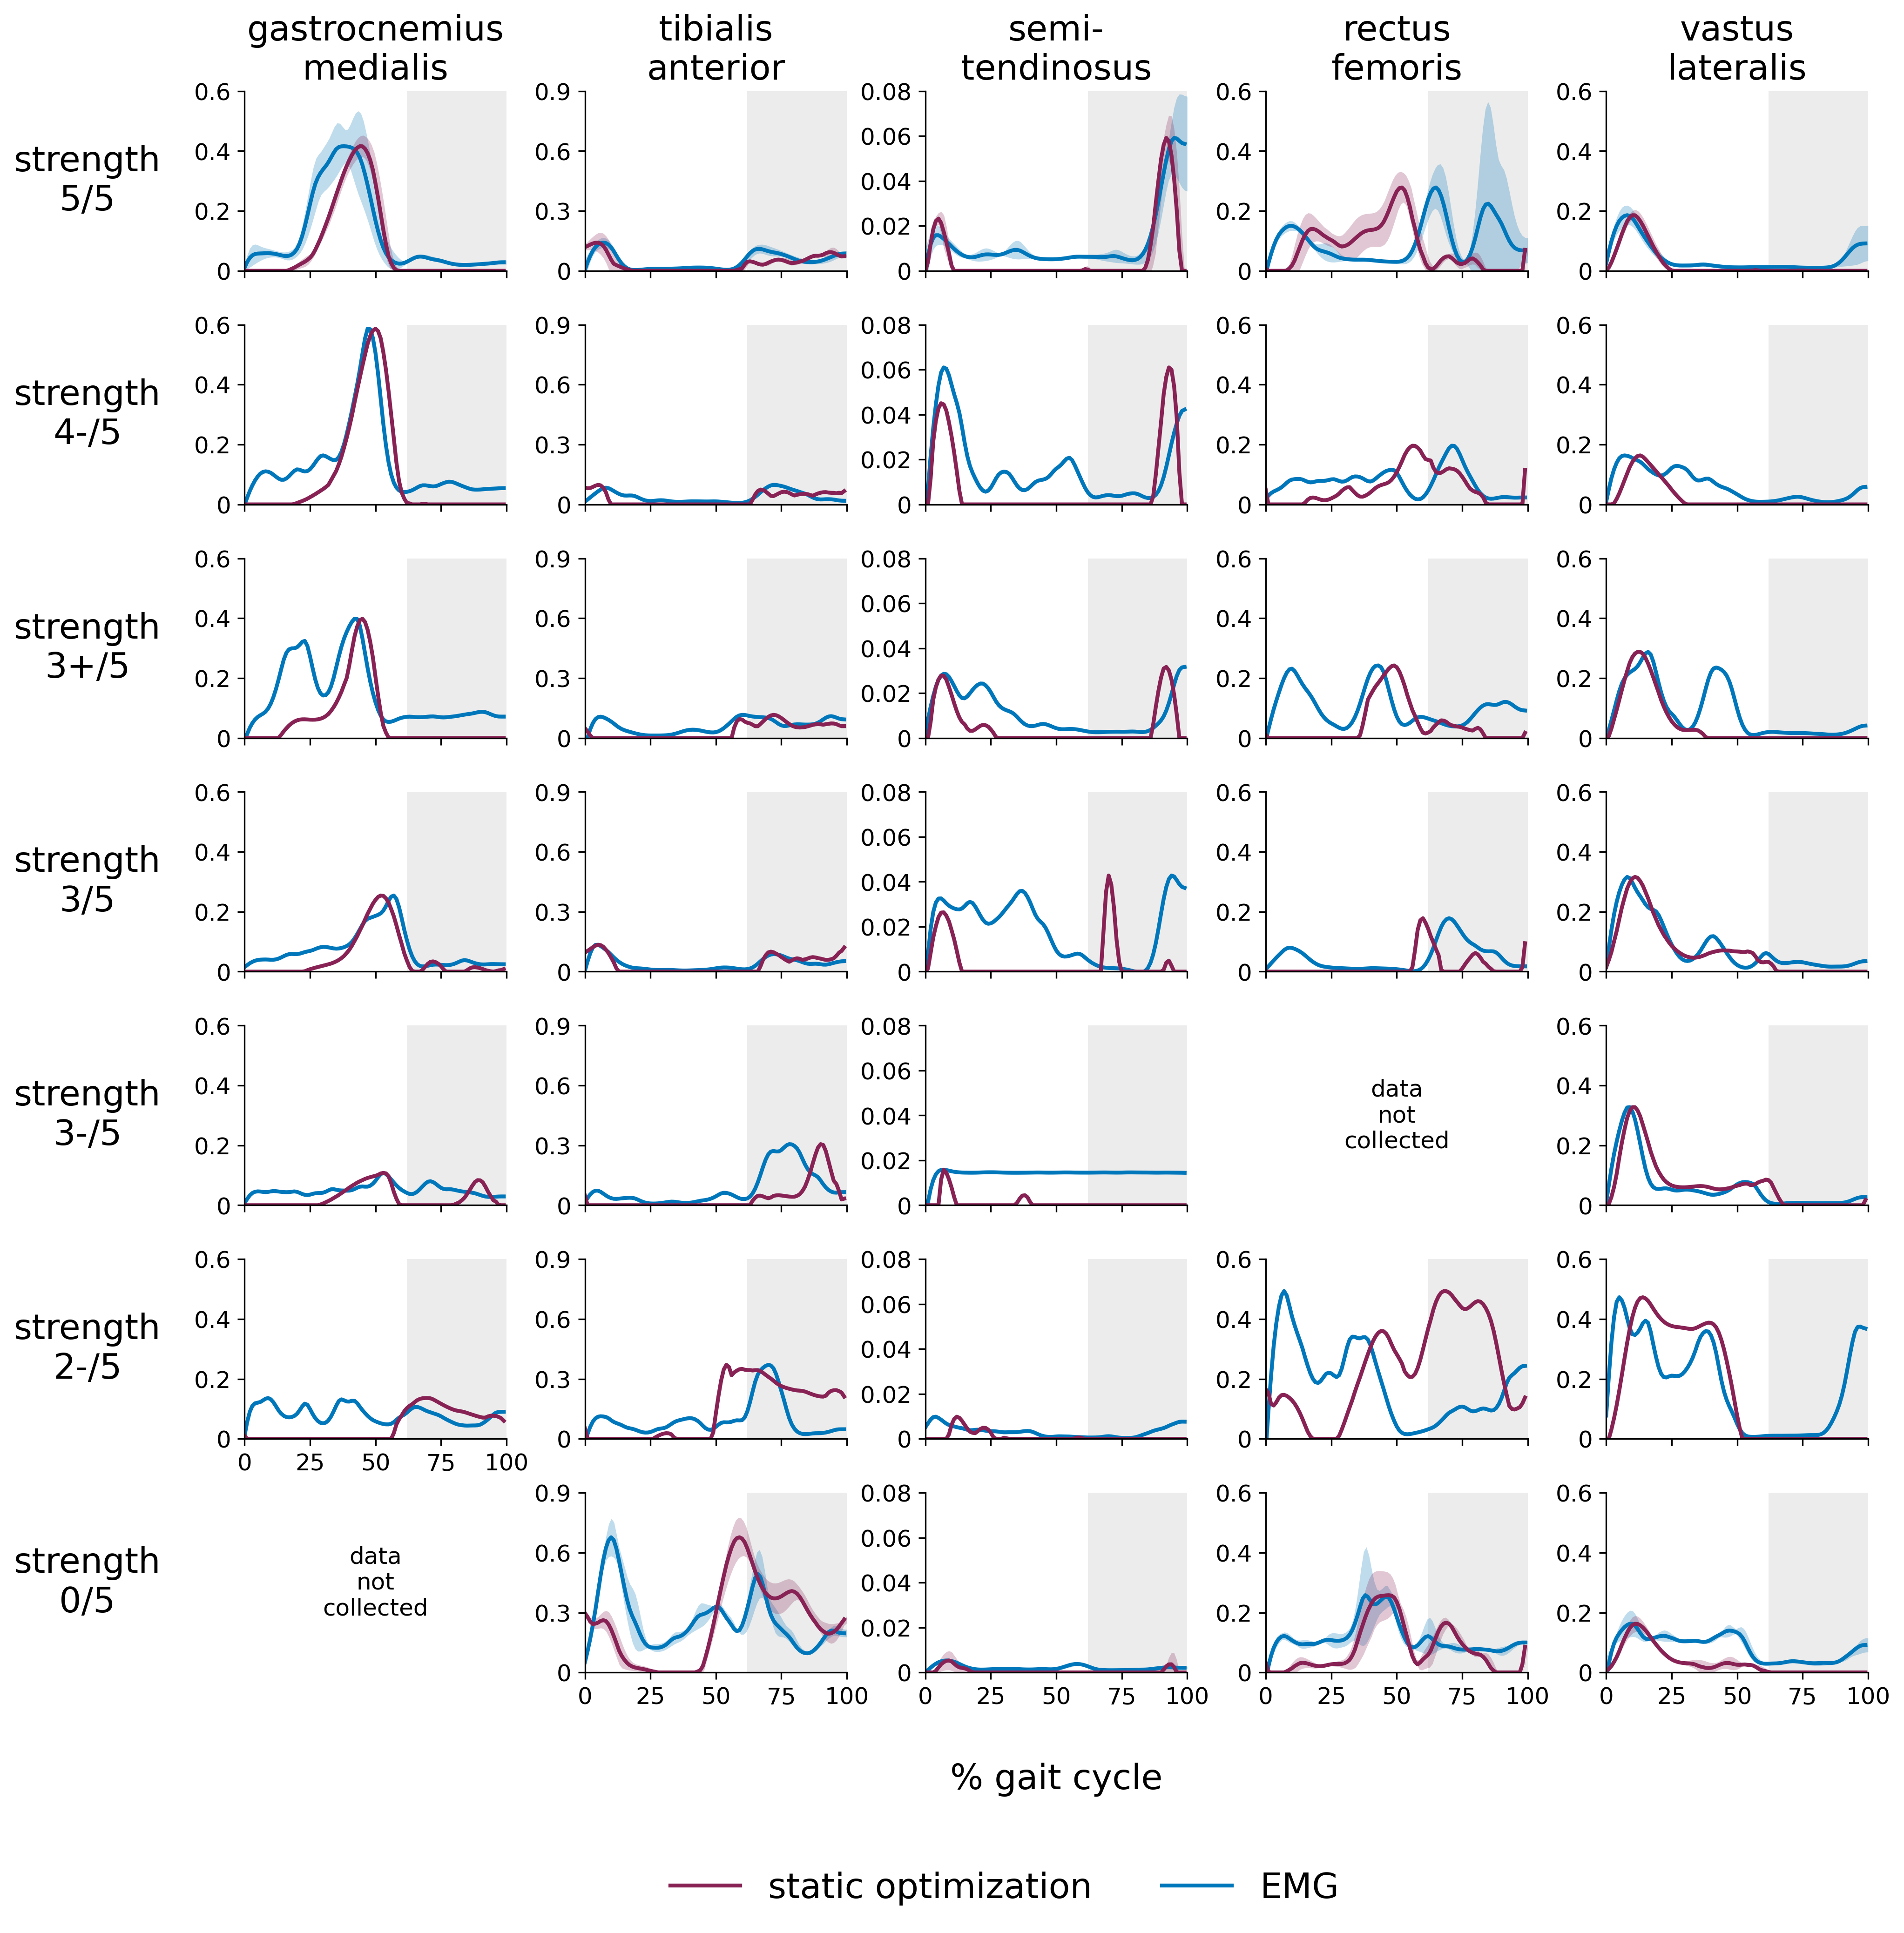

In [7]:
plot_emg_comparisons(emg_demographics)
# note: this cell will not run unless data for the 7 EMG subjects have been downloaded

Both simulated muscle activity (static optimization) and EMG recordings indicated:

- gastrocnemius activity in late stance
- tibialis anterior activity in early stance and swing
- semitendinosus activity in early stance and late swing
- vastus lateralis activity in early stance

EMG recordings indicated that rectus femoris activation timing varied by participant. In general, simulated muscle activity indicated rectus femoris activity in late stance and early swing. 

Peak static optimization activation estimates of the gastrocnemius medialis tended to decrease with plantar flexor muscle strength.

# Walking activity and speed

In [8]:
# average daily steps in SB cohort
avg_daily_steps_mean = np.mean(sb_demographics['average daily steps'].dropna())
avg_daily_steps_sd = np.std(sb_demographics['average daily steps'].dropna())

print('SB avg daily steps: %i (SD %i)' %(avg_daily_steps_mean, avg_daily_steps_sd))

SB avg daily steps: 9656 (SD 3095)


This is comparable to average daily steps previously reported from 7 children with typical development who underwent the same activity monitoring protocol (9589 [SD 3322] steps, [Yasmeh 2016](https://doi.org/10.1080/09638288.2016.1198429)).

In [9]:
# average walking speeds
td_subjects = list(td_demographics['subject'])
td_demographics['walking speed'] = get_average_walking_speeds(td_subjects)

sb_subjects = list(sb_demographics['subject'])
sb_demographics['walking speed'] = get_average_walking_speeds(sb_subjects)

print_ttest(td_demographics, sb_demographics, 'TD', 'SB', 'walking speed')

walking speed: 0.004
	TD: 1.3 (0.1)
	SB: 1.1 (0.1)


Average walking speed, measured from the gait analysis trials, was slower in the group with spina bifida than in the group with typical development.

# Gait waveforms

## Generate summary waveforms of primary cohort

In [10]:
waveform_filename = '../postprocessing/summary_waveforms.pkl'
simulation_directory = '../simulation/'

if not os.path.exists(waveform_filename):
    waveforms = generate_summary_waveforms(simulation_directory)
    waveforms.to_pickle(waveform_filename)
else:
    waveforms = pd.read_pickle(waveform_filename)

waveforms = waveforms.drop(columns=['walk'])

waveforms = average_subject_trials(waveforms)
td_waveforms = waveforms[waveforms['subject'].str.contains('T')].copy()
sb_waveforms = waveforms[waveforms['subject'].str.contains('S')].copy()

td_bodymasses = td_waveforms['bodymass']
sb_bodymasses = sb_waveforms['bodymass']

## Conduct SPM analysis of waveforms

In [11]:
COLOR_TD = 'k'
COLOR_SB = '#CC3311'

KINEM_NAME_MAP = {'hip_flexion': 'hip flexion (deg)',
                  'hip_adduction': 'hip adduction (deg)',
                  'hip_rotation': 'hip internal rotation (deg)',
                  'knee_angle': 'knee flexion (deg)',
                  'ankle_angle': 'ankle dorsiflexion (deg)'}

KINET_NAME_MAP = {'hip_flexion_moment': 'hip flexion moment (N-m/kg)',
                  'hip_adduction_moment': 'hip adduction moment (N-m/kg)',
                  'hip_rotation_moment': 'hip internal rotation moment (N-m/kg)',
                  'knee_angle_moment': 'knee flexion moment (N-m/kg)',
                  'ankle_angle_moment': 'ankle dorsiflexion moment (N-m/kg)'}

GRF_NAME_MAP = {'grfx': 'antero- posterior GRF',
                'grfz': 'medio- lateral GRF',
                'grfy': 'vertical GRF',
                }

FORCE_NAME_MAP = {'walker_knee_on_tibia_in_tibia_shear': 'shear knee force (xBW)',
                  'walker_knee_on_tibia_in_tibia_fy': 'compressive knee force (xBW)',
                  'walker_knee_on_tibia_in_tibia_total': 'total knee force (xBW)',
                  'ankle_on_tibia_in_tibia_shear': 'shear ankle force (xBW)',
                  'ankle_on_tibia_in_tibia_fy': 'compressive ankle force (xBW)',
                  'ankle_on_tibia_in_tibia_total': 'total ankle force (xBW)'}

### Kinematics

0.0319, 6% of gait cycle
0.0001, 27% of gait cycle


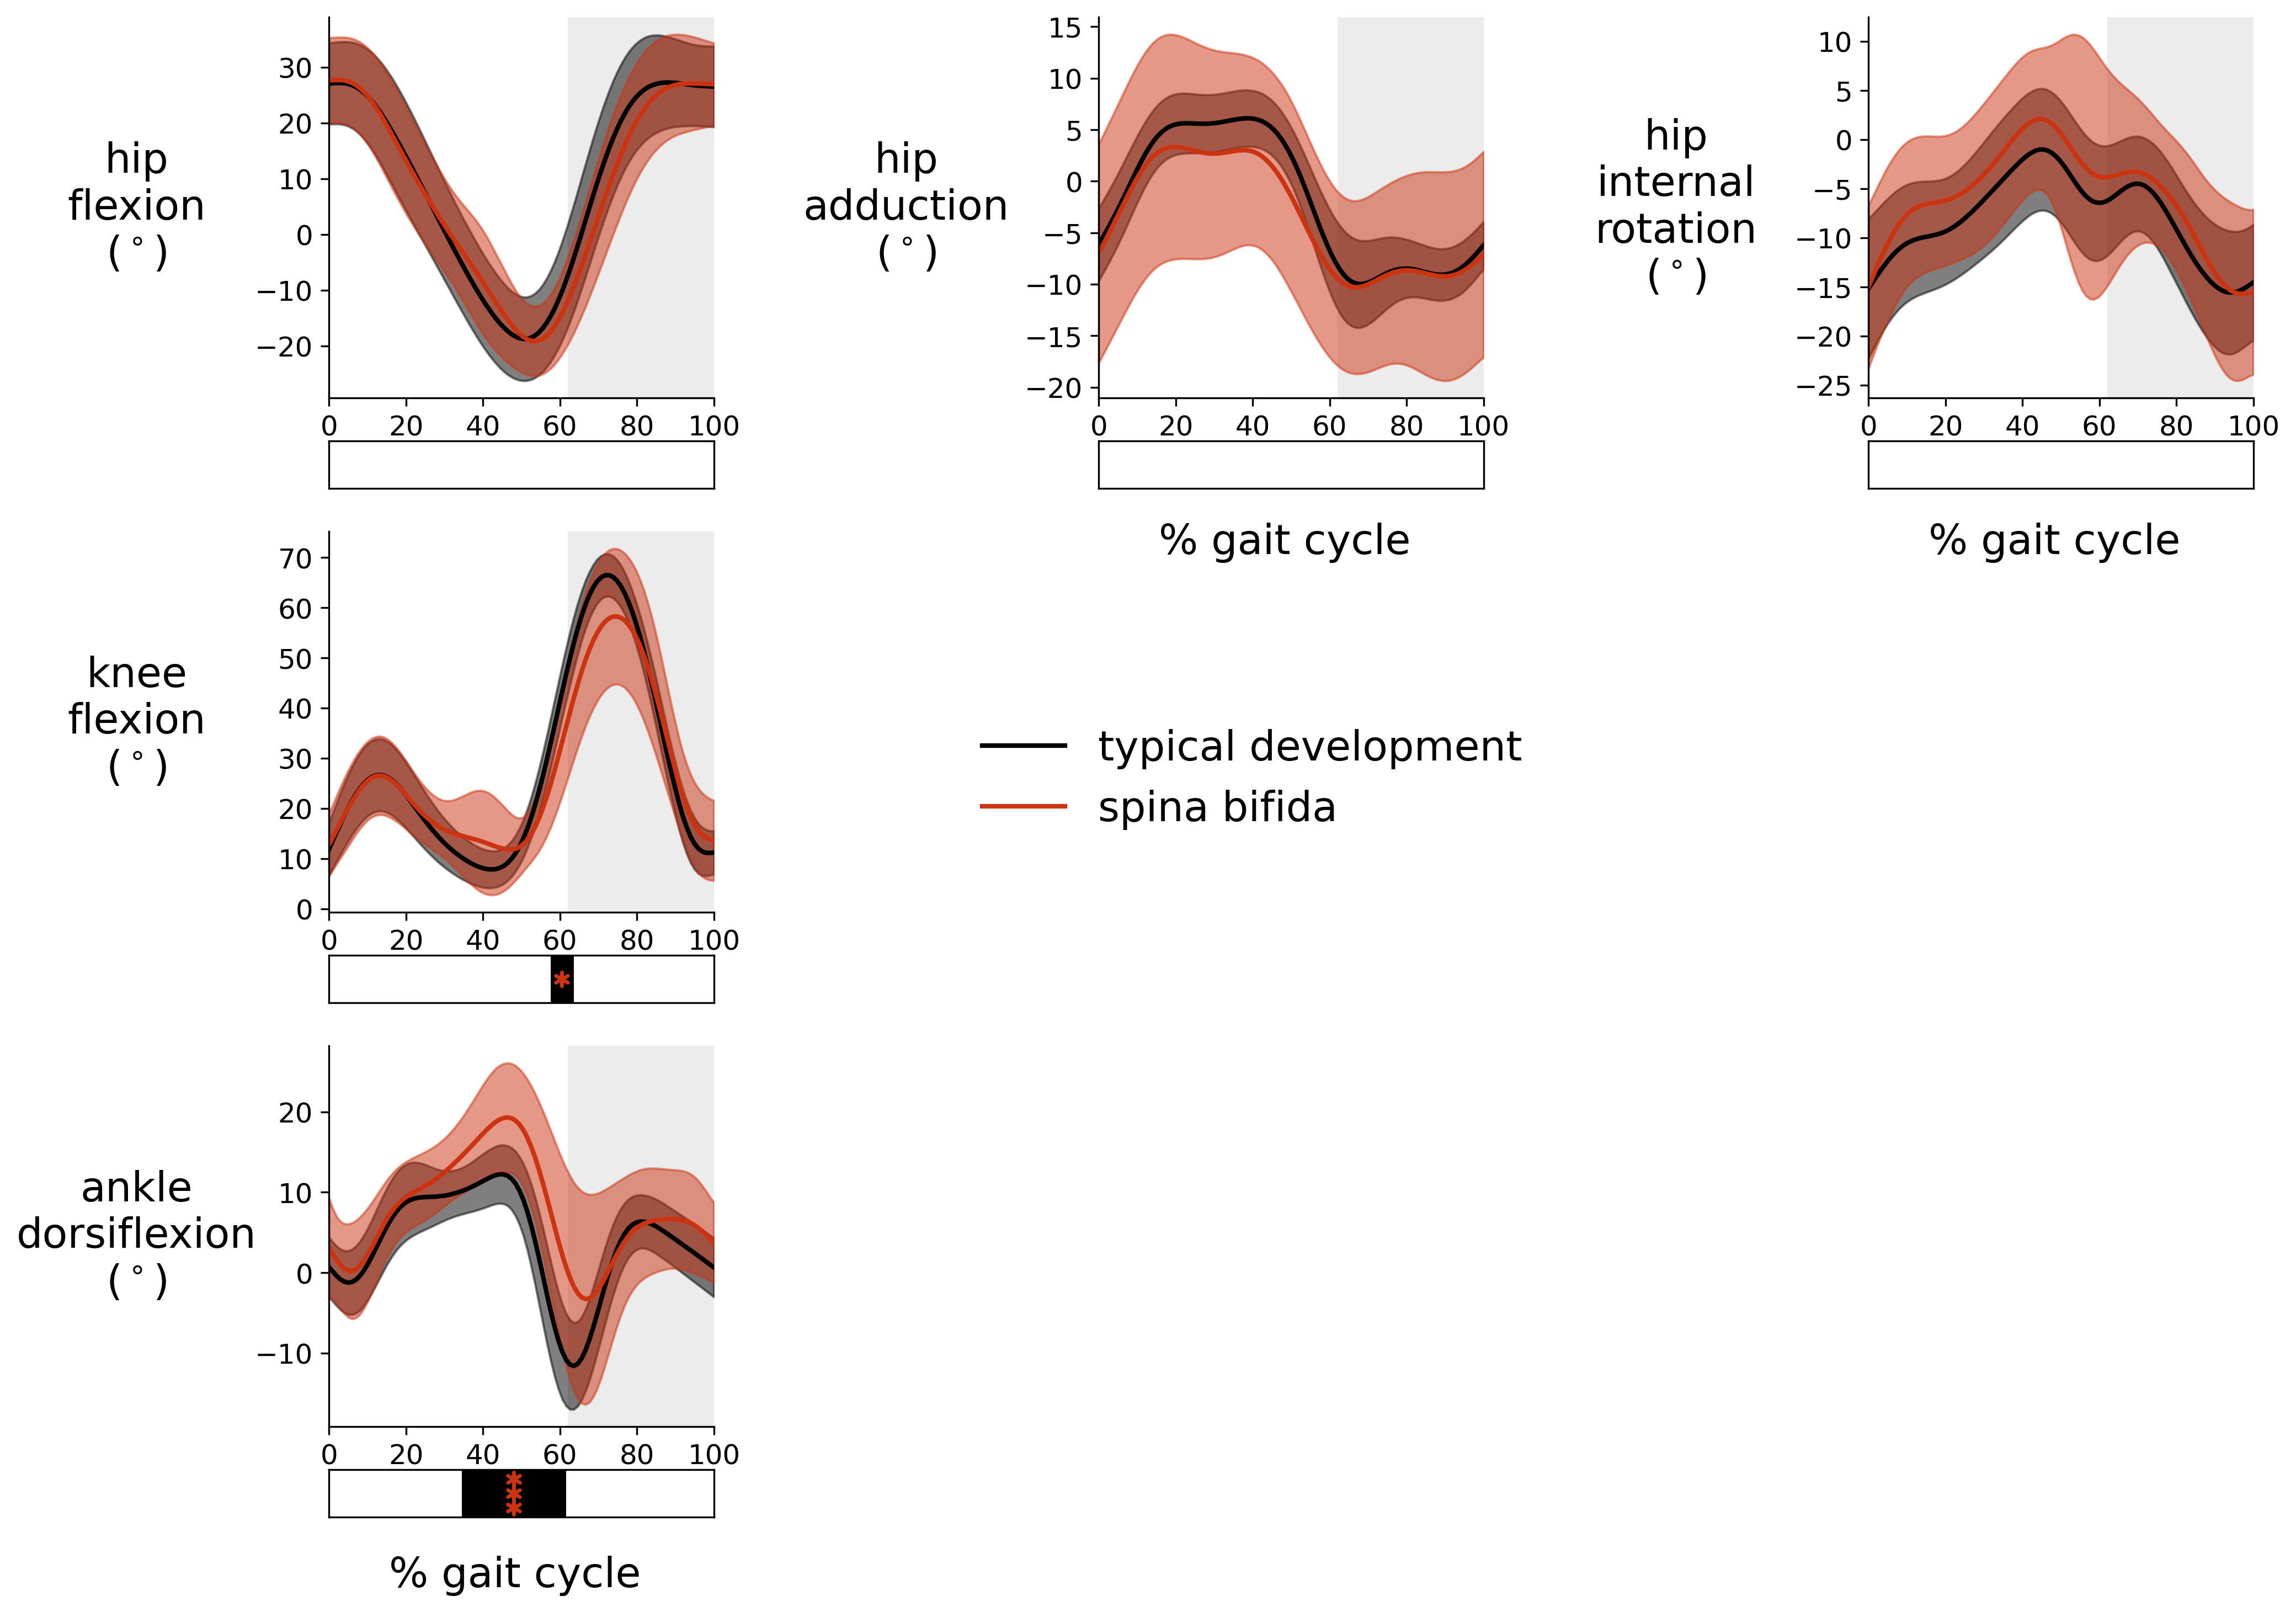

In [12]:
f, axes = plt.subplots(6, 3, gridspec_kw={'height_ratios': [8,1,8,1,8,1]}, dpi=300)
plot_cells = [1, 2, 3, 7, 13]
kinem_names = list(KINEM_NAME_MAP.keys())
for i in range(len(kinem_names)):
    plt.subplot(6, 3, plot_cells[i])
    waveform = kinem_names[i]
    td_waveform = td_waveforms[waveform]
    sb_waveform = sb_waveforms[waveform]
    
    td_data = np.stack(td_waveform.to_numpy())
    sb_data = np.stack(sb_waveform.to_numpy())
    
    ylabel = KINEM_NAME_MAP[waveform][:-6]
    
    ti = run_spm(td_data, sb_data, waveform, color1=COLOR_TD, color2=COLOR_SB)
    
    ylabel = ylabel + ' ($^\circ$)'
    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0,100])
    
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot swing
    ymin, ymax = ax.get_ylim()
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    ax.set_ylim((ymin, ymax))
        
    plt.subplot(6, 3, plot_cells[i] + 3)
    plot_sig(ti, color=COLOR_SB)
    plt.xlim([0,100])

for i in [8, 9, 11, 12, 14, 15, 17, 18]:
    fig = plt.subplot(6, 3, i)
    plt.box(False)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

f.text(0.2, 0.09, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.51, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.82, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(12)
f.set_figwidth(15)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_TD)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_SB)
plt.legend([td_line, sb_line], ['typical development', 'spina bifida'],
           loc='center left', fontsize=18, bbox_to_anchor=(-2.4, 15, 1, 1),
           frameon=False)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/kinematics.jpeg', bbox_inches='tight')

The group with spina bifida exhibited significantly more ankle dorsiflexion in the second half of stance and less plantarflexion at toe-off (p < 0.001) and significantly less knee flexion at toe-off (p = 0.032) compared to the group with typical development. Hip flexion, adduction, and rotation angles did not differ significantly between groups. Greater variances in joint kinematics among participants with spina bifida were observed across teh gait cycle at the hip, knee, and ankle.

In [13]:
# compare max/min values
td_kinematic_peaks = pd.DataFrame()
sb_kinematic_peaks = pd.DataFrame()
for i in range(len(kinem_names)):
    waveform = kinem_names[i]
    td_waveform = td_waveforms[waveform]
    sb_waveform = sb_waveforms[waveform]
    
    td_data = np.stack(td_waveform)
    sb_data = np.stack(sb_waveform)
    
    td_kinematic_peaks[waveform + ' max'] = np.max(td_data, axis=1)
    td_kinematic_peaks[waveform + ' min'] = np.min(td_data, axis=1)
    sb_kinematic_peaks[waveform + ' max'] = np.max(sb_data, axis=1)
    sb_kinematic_peaks[waveform + ' min'] = np.min(sb_data, axis=1)
    
    print_ttest(td_kinematic_peaks, sb_kinematic_peaks, 'TD', 'SB', waveform + ' max', p_digits=4)
    print_ttest(td_kinematic_peaks, sb_kinematic_peaks, 'TD', 'SB', waveform + ' min', p_digits=4)

hip_flexion max: 0.8155
	TD: 29.3 (7.5)
	SB: 29.9 (8.3)
hip_flexion min: 0.6739
	TD: -18.8 (7.5)
	SB: -19.9 (6.1)
hip_adduction max: 0.4003
	TD: 7.3 (2.4)
	SB: 5.0 (9.8)
hip_adduction min: 0.7073
	TD: -11.5 (3.2)
	SB: -12.5 (9.5)
hip_rotation max: 0.0539
	TD: -0.2 (6.0)
	SB: 4.7 (7.2)
hip_rotation min: 0.8971
	TD: -18.0 (6.7)
	SB: -18.4 (8.4)
knee_angle max: 0.0573
	TD: 66.8 (4.2)
	SB: 60.6 (11.0)
knee_angle min: 0.6052
	TD: 6.7 (3.1)
	SB: 7.5 (4.8)
ankle_angle max: 0.0032
	TD: 13.4 (4.0)
	SB: 19.9 (6.6)
ankle_angle min: 0.0983
	TD: -12.3 (5.3)
	SB: -7.4 (9.7)


### Joint moments

0.0251, 3% of gait cycle
0.0403, 2% of gait cycle
0.0000, 10% of gait cycle
0.0370, 2% of gait cycle


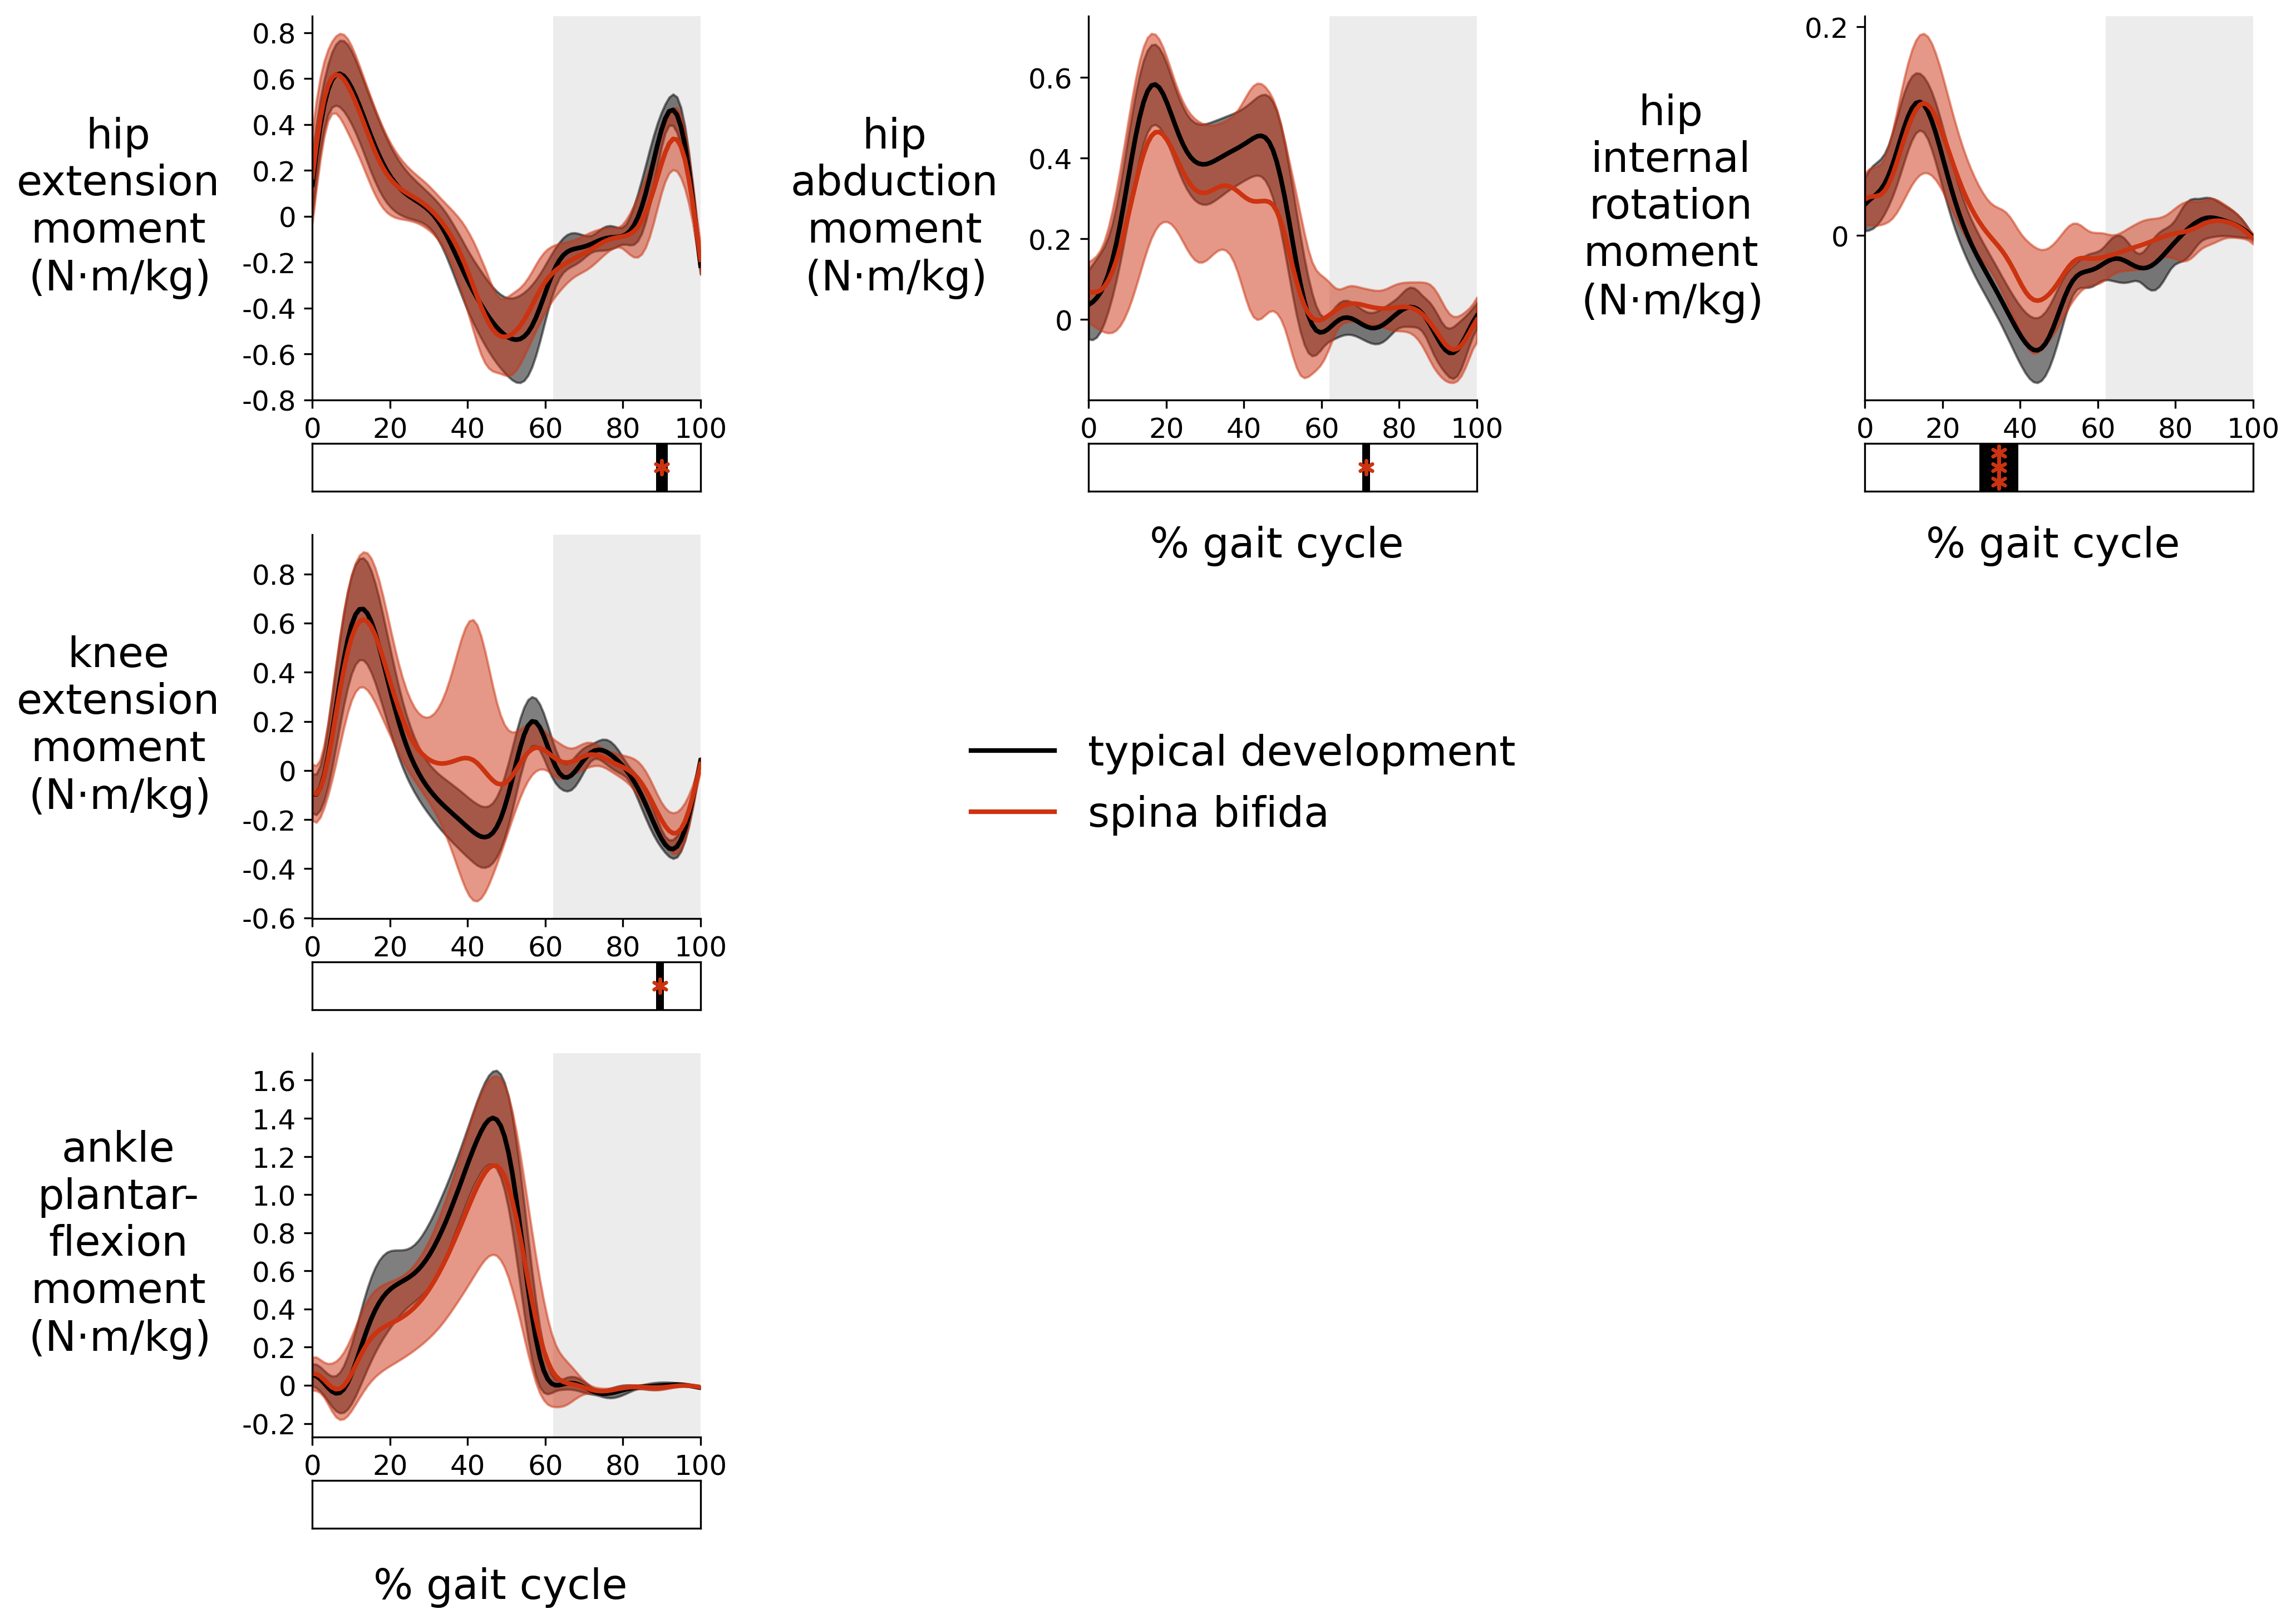

In [14]:
f, axes = plt.subplots(6, 3, gridspec_kw={'height_ratios': [8,1,8,1,8,1]} , dpi=300)
plot_cells = [1, 2, 3, 7, 13]
kinet_names = list(KINET_NAME_MAP.keys())
for i in range(len(kinet_names)):
    plt.subplot(6, 3, plot_cells[i])
    waveform = kinet_names[i]
    td_waveform = td_waveforms[waveform]
    sb_waveform = sb_waveforms[waveform]
    
    td_data = np.stack(np.divide(td_waveform, td_bodymasses))
    sb_data = np.stack(np.divide(sb_waveform, sb_bodymasses))
    
    if waveform == 'ankle_angle_moment':
        td_data = -1*td_data
        sb_data = -1*sb_data
        ylabel = 'ankle plantar- flexion moment'
    elif waveform == 'hip_adduction_moment':
        td_data = -1*td_data
        sb_data = -1*sb_data
        ylabel = 'hip abduction moment'
    elif waveform == 'hip_flexion_moment':
        td_data = -1*td_data
        sb_data = -1*sb_data
        ylabel = 'hip extension moment'
    elif waveform == 'knee_angle_moment':
        td_data = -1*td_data
        sb_data = -1*sb_data
        ylabel = 'knee extension moment'
    else:
        ylabel = KINET_NAME_MAP[waveform][:-9]
    
    ti = run_spm(td_data, sb_data, waveform, color1=COLOR_TD, color2=COLOR_SB)
    ylabel = ylabel + ' (N$\cdot$m/kg)'
    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.xlim([0,100])

    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
        
    ymin, ymax = ax.get_ylim()  
    yticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4,
             1.6, 1.8, 2.0]
    plt.yticks(yticks, yticks, fontsize=12)
    
    # plot swing
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    
    plt.ylim((ymin, ymax))
        
    plt.subplot(6, 3, plot_cells[i] + 3)
    plot_sig(ti, color=COLOR_SB)
    plt.xlim([0,100])

for i in [8, 9, 11, 12, 14, 15, 17, 18]:
    fig = plt.subplot(6, 3, i)
    plt.box(False)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

f.text(0.2, 0.09, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.51, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.82, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(12)
f.set_figwidth(15)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_TD)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_SB)
plt.legend([td_line, sb_line], ['typical development', 'spina bifida'], 
           loc='center left', fontsize=18, bbox_to_anchor=(-2.4, 15, 1, 1),
           frameon=False)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/moments.jpeg', bbox_inches='tight')

Few statistically significant differences in joint moments were identified between groups. Differences in hip extension moments (p = 0.025), hip abduction moments (p=0.040), and knee extension moments (p = 0.037) occurred only in swing and for periods less than 4% of the gait cycle. Significant differences were found in hip rotation moments in mid-stance (p < 0.001). As with kinematics, joint moment variances were greater in the group with spina bifida than in the group with typical development.

In [15]:
# compare max/min values
td_moment_peaks = pd.DataFrame()
sb_moment_peaks = pd.DataFrame()
for i in range(len(kinet_names)):
    waveform = kinet_names[i]
    td_waveform = td_waveforms[waveform]
    sb_waveform = sb_waveforms[waveform]
    
    td_data = np.stack(np.divide(td_waveform, td_bodymasses))
    sb_data = np.stack(np.divide(sb_waveform, sb_bodymasses))
    
    td_data = np.abs(td_data)
    sb_data = np.abs(sb_data)
    
    td_moment_peaks[waveform + ' max'] = np.max(td_data, axis=1)
    td_moment_peaks[waveform + ' min'] = np.min(td_data, axis=1)
    sb_moment_peaks[waveform + ' max'] = np.max(sb_data, axis=1)
    sb_moment_peaks[waveform + ' min'] = np.min(sb_data, axis=1)
    
    print_ttest(td_moment_peaks, sb_moment_peaks, 'TD', 'SB', waveform + ' max', p_digits=4)
    print_ttest(td_moment_peaks, sb_moment_peaks, 'TD', 'SB', waveform + ' min', p_digits=4)

hip_flexion_moment max: 0.4226
	TD: 0.7 (0.1)
	SB: 0.7 (0.2)
hip_flexion_moment min: 0.1136
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)
hip_adduction_moment max: 0.2705
	TD: 0.6 (0.1)
	SB: 0.5 (0.2)
hip_adduction_moment min: 0.6635
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)
hip_rotation_moment max: 0.8332
	TD: 0.1 (0.0)
	SB: 0.1 (0.1)
hip_rotation_moment min: 0.4722
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)
knee_angle_moment max: 0.8652
	TD: 0.7 (0.2)
	SB: 0.7 (0.4)
knee_angle_moment min: 0.9057
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)
ankle_angle_moment max: 0.0983
	TD: 1.4 (0.2)
	SB: 1.2 (0.5)
ankle_angle_moment min: 0.9934
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)


### Ankle power

0.0137, 4% of gait cycle
0.0404, 4% of gait cycle


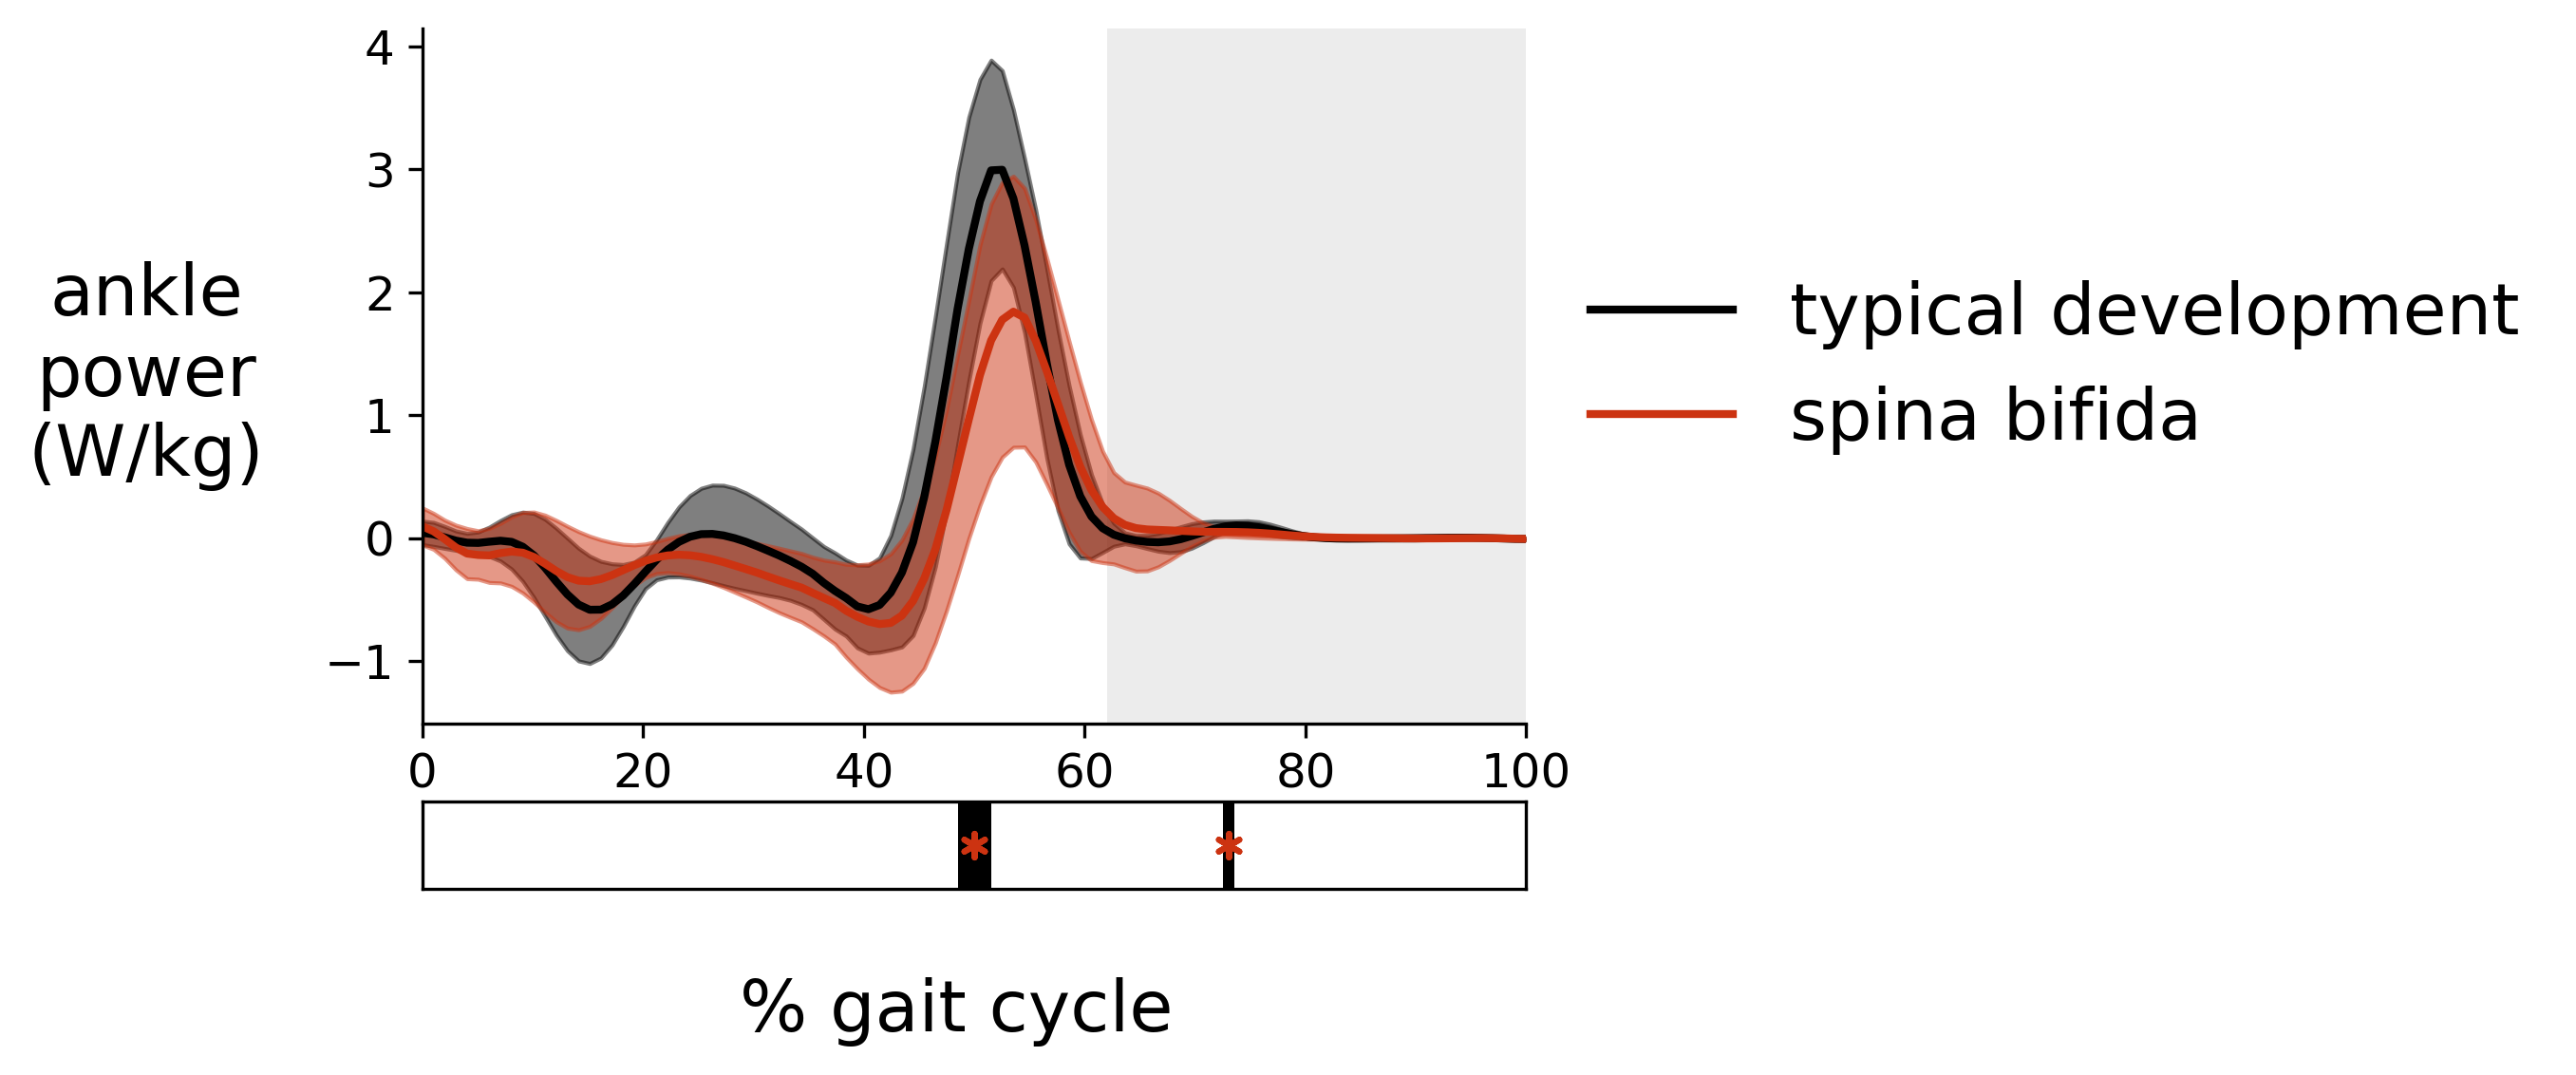

In [16]:
waveform = 'ankle_angle_power'
ylabel = 'ankle power (W/kg)'

td_waveform = td_waveforms[waveform]
sb_waveform = sb_waveforms[waveform]

td_data = np.stack(np.divide(td_waveform, td_bodymasses))
sb_data = np.stack(np.divide(sb_waveform, sb_bodymasses))

f, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8,1]} , dpi=300)
plt.subplot(2, 1, 1)
ti = run_spm(td_data, sb_data, waveform, color1=COLOR_TD, color2=COLOR_SB)
ylabel = ylabel.replace(' ', '\n')
plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,100])

ax = plt.gca()
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plot swing
ymin, ymax = ax.get_ylim()
plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                 linewidth=0, zorder=0)
ax.set_ylim((ymin, ymax))

plt.subplot(2, 1, 2)
plot_sig(ti, color=COLOR_SB)
plt.xlim([0,100])

f.text(0.5, 0, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(4)
f.set_figwidth(5)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_TD)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_SB)
plt.legend([td_line, sb_line], ['typical development', 'spina bifida'],
           loc='center left', fontsize=18, bbox_to_anchor=(1, 5.5, 1, 1),
           frameon=False)
plt.subplots_adjust(wspace=1)

Ankle power was significantly lower in the group with spina bifida (p < 0.05) for short periods of late stance and swing.

### Ground reaction forces

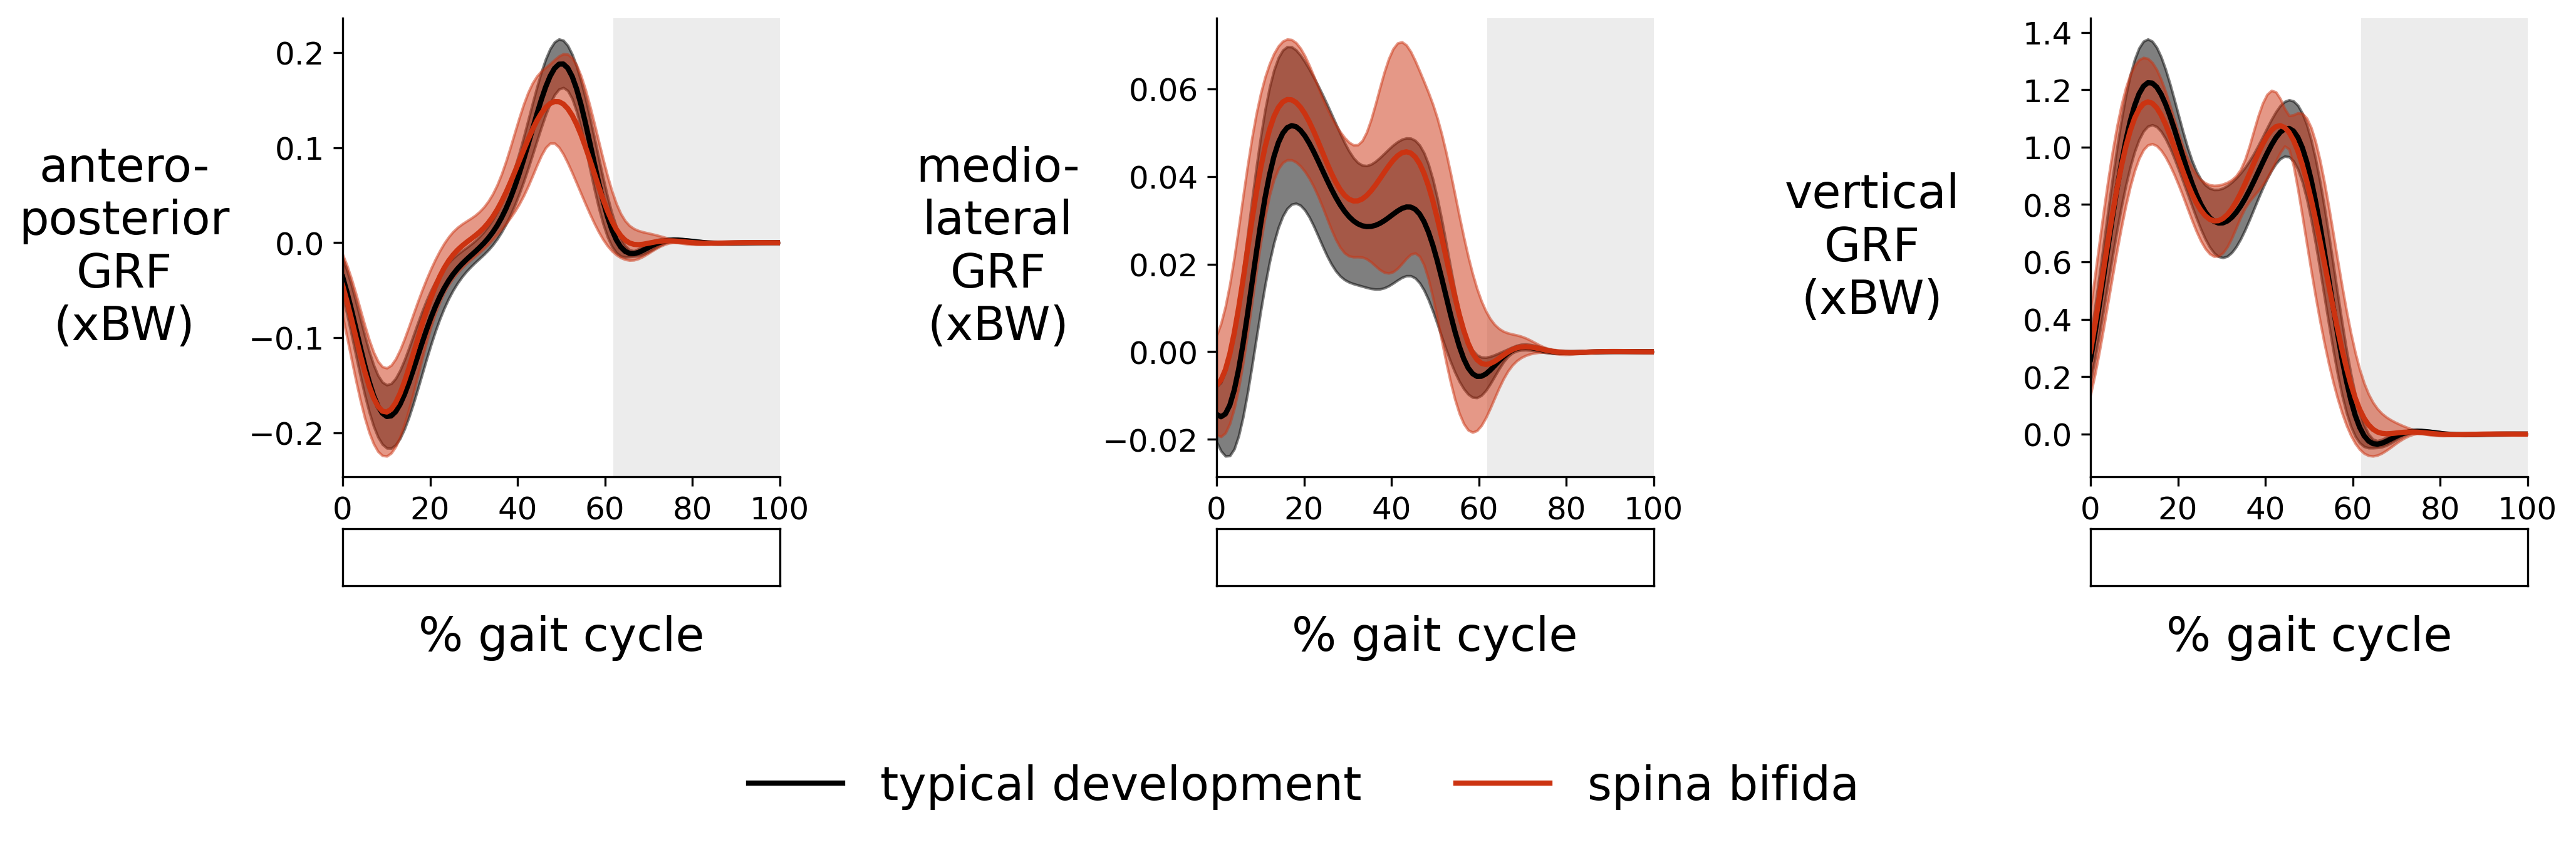

In [17]:
f, axes = plt.subplots(2, 3, gridspec_kw={'height_ratios': [8, 1]}, dpi=300)
plot_cells = [1, 2, 3]
grf_names = list(GRF_NAME_MAP.keys())
for i in range(len(grf_names)):
    plt.subplot(2, 3, plot_cells[i])
    waveform = grf_names[i]

    sb_waveform = sb_waveforms[waveform]
    td_waveform = td_waveforms[waveform]

    sb_data = np.stack(np.divide(sb_waveform, 9.81*sb_bodymasses))
    td_data = np.stack(np.divide(td_waveform, 9.81*td_bodymasses))
    
    ti = run_spm(td_data, sb_data, waveform, color1=COLOR_TD, color2=COLOR_SB)
    ylabel = GRF_NAME_MAP[waveform] + ' (xBW)'
    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0,100])
    plt.xlabel('% gait cycle', fontsize=18)
    
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot swing
    ymin, ymax = ax.get_ylim()
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    ax.set_ylim((ymin, ymax))
    
    plt.subplot(2, 3, plot_cells[i] + 3)
    plot_sig(ti, color=COLOR_SB)
    plt.xlim([0,100])

f.set_figheight(4)
f.set_figwidth(15)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_TD)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_SB)
plt.legend([td_line, sb_line], ['typical development', 'spina bifida'], 
           loc='center', fontsize=18, bbox_to_anchor=(-2.3, -4, 1, 1), frameon=False,
           ncol=2)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/grfs.jpeg', bbox_inches='tight')

No differences between the two groups were detected in mean ground reaction forces.

### Tibial forces

In [18]:
def get_shear_and_total_forces(waveforms, force):
    """calculate shear and total forces from component joint forces.
    
    Args:
        waveforms (pd DataFrame): dataframe containing component waveforms.
        force (str): force name.
        
    Returns:
        shear_forces (np array): calculated shear force magnitudes.
        total_forces (np array): calculated total joint force magnitudes.
        
    """
    fx = np.stack(waveforms[force + '_fx'].to_numpy())
    fy = np.stack(waveforms[force + '_fy'].to_numpy())
    fz = np.stack(waveforms[force + '_fz'].to_numpy())

    shear_forces = np.sqrt(np.square(fx) + np.square(fz))
    total_forces = np.sqrt(np.square(fx) + np.square(fy) + np.square(fz))

    return shear_forces, total_forces

In [19]:
# shear forces
td_knee_shear, td_knee_total = get_shear_and_total_forces(td_waveforms, 'walker_knee_on_tibia_in_tibia')
td_ankle_shear, td_ankle_total = get_shear_and_total_forces(td_waveforms, 'ankle_on_tibia_in_tibia')
sb_knee_shear, sb_knee_total = get_shear_and_total_forces(sb_waveforms, 'walker_knee_on_tibia_in_tibia')
sb_ankle_shear, sb_ankle_total = get_shear_and_total_forces(sb_waveforms, 'ankle_on_tibia_in_tibia')

td_waveforms['walker_knee_on_tibia_in_tibia_shear'] = td_knee_shear.tolist()
td_waveforms['walker_knee_on_tibia_in_tibia_total'] = td_knee_total.tolist()
td_waveforms['ankle_on_tibia_in_tibia_shear'] = td_ankle_shear.tolist()
td_waveforms['ankle_on_tibia_in_tibia_total'] = td_ankle_total.tolist()

sb_waveforms['walker_knee_on_tibia_in_tibia_shear'] = sb_knee_shear.tolist()
sb_waveforms['walker_knee_on_tibia_in_tibia_total'] = sb_knee_total.tolist()
sb_waveforms['ankle_on_tibia_in_tibia_shear'] = sb_ankle_shear.tolist()
sb_waveforms['ankle_on_tibia_in_tibia_total'] = sb_ankle_total.tolist()

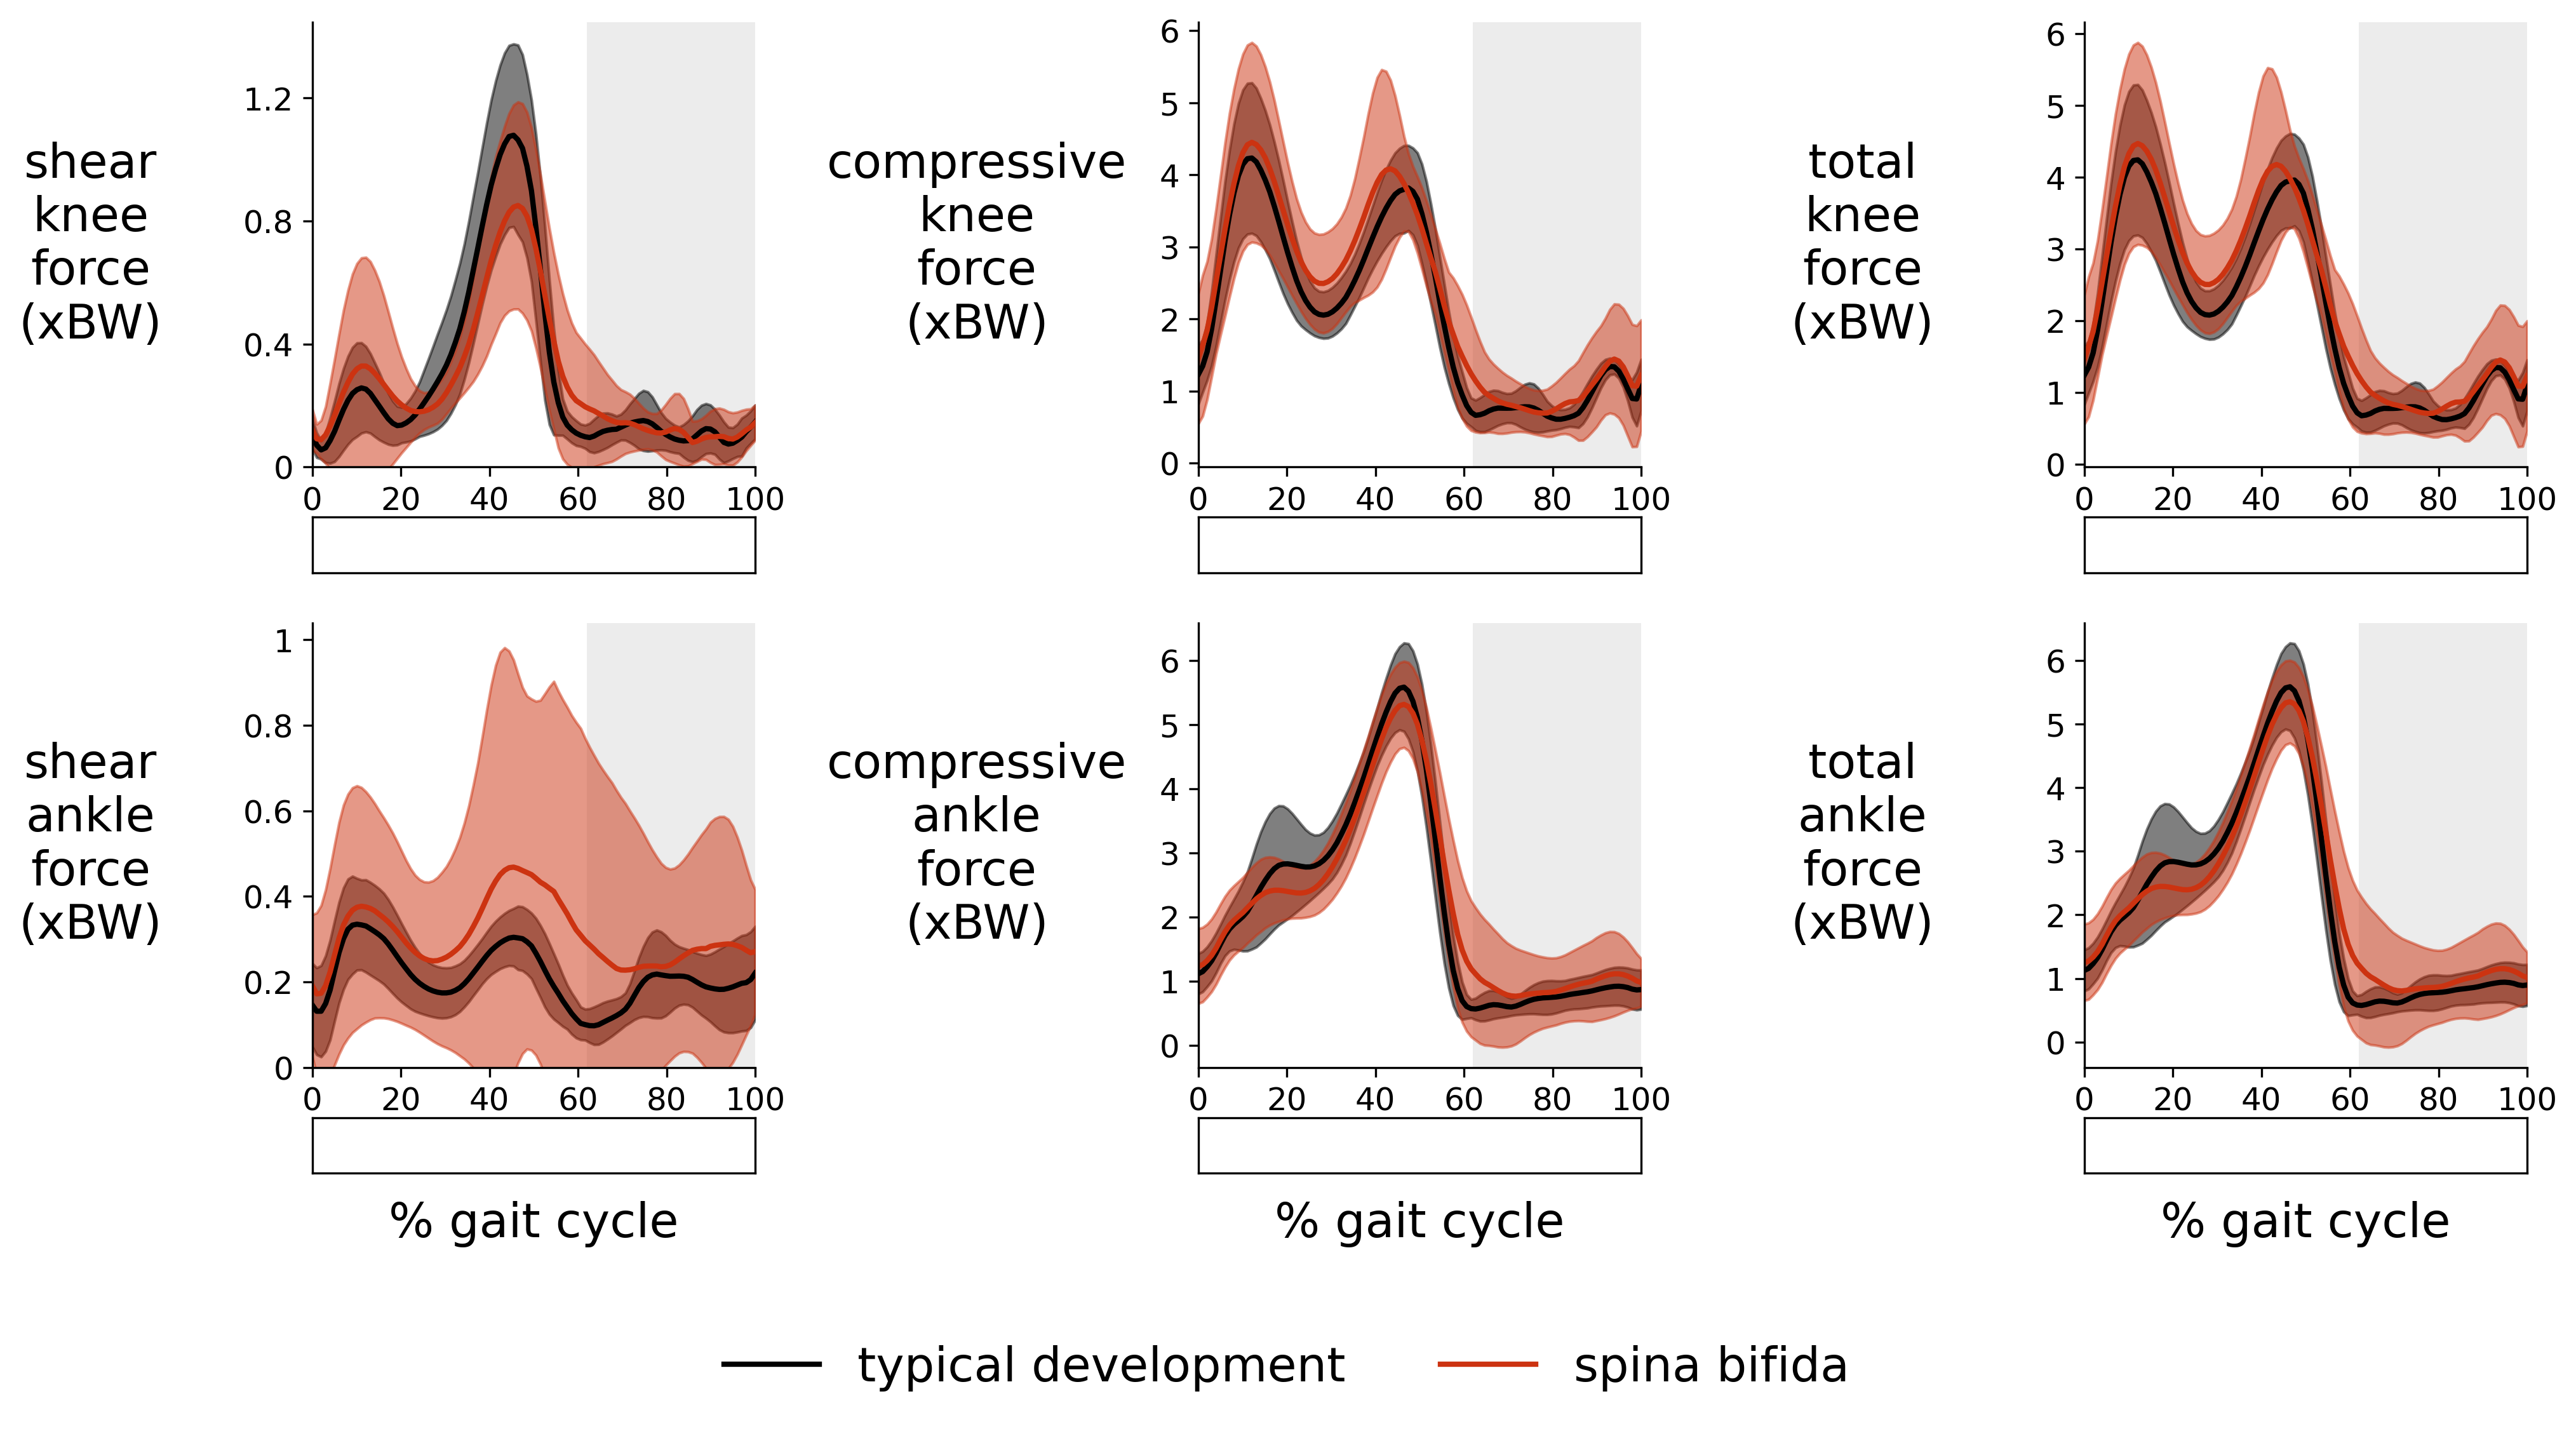

In [20]:
f, axes = plt.subplots(4, 3, gridspec_kw={'height_ratios': [8, 1, 8, 1]}, dpi=300)
plot_cells = [1, 2, 3, 7, 8, 9]
force_names = list(FORCE_NAME_MAP.keys())
for i in range(len(force_names)):
    plt.subplot(4, 3, plot_cells[i])
    waveform = force_names[i]
    
    if 'fy' in waveform:   
        sb_waveform = sb_waveforms[waveform]
        td_waveform = td_waveforms[waveform]

        sb_data = np.stack(np.divide(sb_waveform, 9.81*sb_bodymasses))
        td_data = np.stack(np.divide(td_waveform, 9.81*td_bodymasses))
    else:
        td_waveform = np.array([td_waveforms[waveform].iloc[i] for i in range(len(td_waveforms))])
        sb_waveform = np.array([sb_waveforms[waveform].iloc[i] for i in range(len(sb_waveforms))])
        
        td_data = np.divide(td_waveform, 9.81*np.array(td_bodymasses).reshape([16, 1]))
        sb_data = np.divide(sb_waveform, 9.81*np.array(sb_bodymasses).reshape([16, 1]))    
    
    if waveform == 'walker_knee_on_tibia_in_tibia_fy': # invert
        sb_data = -1*sb_data
        td_data = -1*td_data
    
    ti = run_spm(td_data, sb_data, waveform, color1=COLOR_TD, color2=COLOR_SB)
    ylabel = FORCE_NAME_MAP[waveform]
    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0,100])
    
    if plot_cells[i] in [7, 8, 9]:
        plt.xlabel('% gait cycle', fontsize=18)
    
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if 'shear' in ylabel: # don't let shear dip below zero
        _, ylim = ax.get_ylim()
        if 'ankle' in ylabel:
            yticks = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
        elif 'knee' in ylabel:
            yticks = [0, 0.4, 0.8, 1.2, 1.6, 2]
        plt.yticks(yticks, yticks)
        plt.ylim([0, ylim])
        
    # plot swing
    ymin, ymax = ax.get_ylim()
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    ax.set_ylim((ymin, ymax))
            
    plt.subplot(4, 3, plot_cells[i] + 3)
    plot_sig(ti, color=COLOR_SB)
    plt.xlim([0,100])
    
f.set_figheight(8)
f.set_figwidth(15)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_TD)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_SB)
plt.legend([td_line, sb_line], ['typical development', 'spina bifida'],
           loc='center', fontsize=18, bbox_to_anchor=(-2.3, -4, 1, 1), frameon=False,
           ncol=2)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/joint_forces.jpeg', bbox_inches='tight')

No differences between the two groups were detected in shear, compressive, or total tibial forces at the knee and ankle.

In [21]:
td_force_peaks = pd.DataFrame()
sb_force_peaks = pd.DataFrame()
for i in range(len(force_names)):
    waveform = force_names[i]
    
    if waveform == 'walker_knee_on_tibia_in_tibia_shear':
        td_data = np.divide(td_knee_shear, 9.81*np.array(td_bodymasses).reshape([16,1]))
        sb_data = np.divide(sb_knee_shear, 9.81*np.array(sb_bodymasses).reshape([16,1]))
    elif waveform == 'ankle_on_tibia_in_tibia_shear':
        td_data = np.divide(td_ankle_shear, 9.81*np.array(td_bodymasses).reshape([16,1]))
        sb_data = np.divide(sb_ankle_shear, 9.81*np.array(sb_bodymasses).reshape([16,1]))
    elif waveform == 'walker_knee_on_tibia_in_tibia_total':
        td_data = np.divide(td_knee_total, 9.81*np.array(td_bodymasses).reshape([16,1]))
        sb_data = np.divide(sb_knee_total, 9.81*np.array(sb_bodymasses).reshape([16,1]))
    elif waveform == 'ankle_on_tibia_in_tibia_total':
        td_data = np.divide(td_ankle_total, 9.81*np.array(td_bodymasses).reshape([16,1]))
        sb_data = np.divide(sb_ankle_total, 9.81*np.array(sb_bodymasses).reshape([16,1]))
    else:   
        td_waveform = td_waveforms[waveform]
        sb_waveform = sb_waveforms[waveform]

        td_data = np.stack(np.divide(td_waveform, 9.81*td_bodymasses))
        sb_data = np.stack(np.divide(sb_waveform, 9.81*sb_bodymasses))
            
    td_data = np.abs(td_data)
    sb_data = np.abs(sb_data)
    
    td_force_peaks[waveform + ' max'] = np.max(td_data, axis=1)
    td_force_peaks[waveform + ' min'] = np.min(td_data, axis=1)
    sb_force_peaks[waveform + ' max'] = np.max(sb_data, axis=1)
    sb_force_peaks[waveform + ' min'] = np.min(sb_data, axis=1)
    
    print_ttest(td_force_peaks, sb_force_peaks, 'TD', 'SB', waveform + ' max', p_digits=4)
    print_ttest(td_force_peaks, sb_force_peaks, 'TD', 'SB', waveform + ' min', p_digits=4)

walker_knee_on_tibia_in_tibia_shear max: 0.2055
	TD: 1.1 (0.3)
	SB: 1.0 (0.3)
walker_knee_on_tibia_in_tibia_shear min: 0.5030
	TD: 0.0 (0.0)
	SB: 0.0 (0.0)
walker_knee_on_tibia_in_tibia_fy max: 0.2188
	TD: 4.5 (0.9)
	SB: 5.1 (1.4)
walker_knee_on_tibia_in_tibia_fy min: 0.4029
	TD: 0.5 (0.1)
	SB: 0.6 (0.3)
walker_knee_on_tibia_in_tibia_total max: 0.2226
	TD: 4.6 (0.9)
	SB: 5.2 (1.4)
walker_knee_on_tibia_in_tibia_total min: 0.4027
	TD: 0.5 (0.1)
	SB: 0.6 (0.3)
ankle_on_tibia_in_tibia_shear max: 0.1470
	TD: 0.4 (0.1)
	SB: 0.6 (0.6)
ankle_on_tibia_in_tibia_shear min: 0.3562
	TD: 0.1 (0.0)
	SB: 0.1 (0.2)
ankle_on_tibia_in_tibia_fy max: 0.3059
	TD: 5.7 (0.6)
	SB: 5.5 (0.7)
ankle_on_tibia_in_tibia_fy min: 0.2541
	TD: 0.5 (0.1)
	SB: 0.6 (0.4)
ankle_on_tibia_in_tibia_total max: 0.4150
	TD: 5.7 (0.6)
	SB: 5.5 (0.7)
ankle_on_tibia_in_tibia_total min: 0.2518
	TD: 0.5 (0.1)
	SB: 0.6 (0.5)


# Plantar flexor muscle strength and tibial forces

In [22]:
def get_peak_forces(waveforms):
    """extract peak forces from force waveforms.
    
    Args:
        waveforms (pd DataFrame): dataframe containing tibial force waveforms.
    
    Returns:
        peak_forces (pd DataFrame): dataframe containing peaks of the tibial force
                                    waveforms.
    """
    tibial_force_names = ['walker_knee_on_tibia_in_tibia_shear',
                          'ankle_on_tibia_in_tibia_shear',
                          'walker_knee_on_tibia_in_tibia_fy', 
                          'ankle_on_tibia_in_tibia_fy']
    tibial_forces = waveforms[tibial_force_names].copy()
    tibial_forces = tibial_forces.to_numpy()
    
    peak_forces = []
    for i in range(tibial_forces.shape[0]):
        row_data = tibial_forces[i]
        new_peak_data = []
        for j in range(len(row_data)):
            data = row_data[j]
            tibial_force_name = tibial_force_names[j]
            if tibial_force_name == 'walker_knee_on_tibia_in_tibia_fy':
                new_peak_data.append(np.min(data))
            else:
                new_peak_data.append(np.max(data))
        peak_forces.append(new_peak_data)

    peak_forces = pd.DataFrame(peak_forces, columns=[tibial_force_name + '_peak' for
                                                     tibial_force_name in
                                                     tibial_force_names])

    peak_forces['subject'] = list(waveforms['subject'])
    peak_forces['bodymass'] = list(waveforms['bodymass'])
    peak_forces['side'] = list(waveforms['side'])
    
    return peak_forces

td_force_peaks = get_peak_forces(td_waveforms)
sb_force_peaks = get_peak_forces(sb_waveforms)

In [23]:
pf_strengths, _ = get_analyzed_side_pf_strength(sb_demographics)
sb_demographics['plantar flexor strength'] = pf_strengths
pf_strengths = sb_demographics[['subject', 'plantar flexor strength']].copy()

sb_force_peaks = sb_force_peaks.merge(pf_strengths, on='subject')

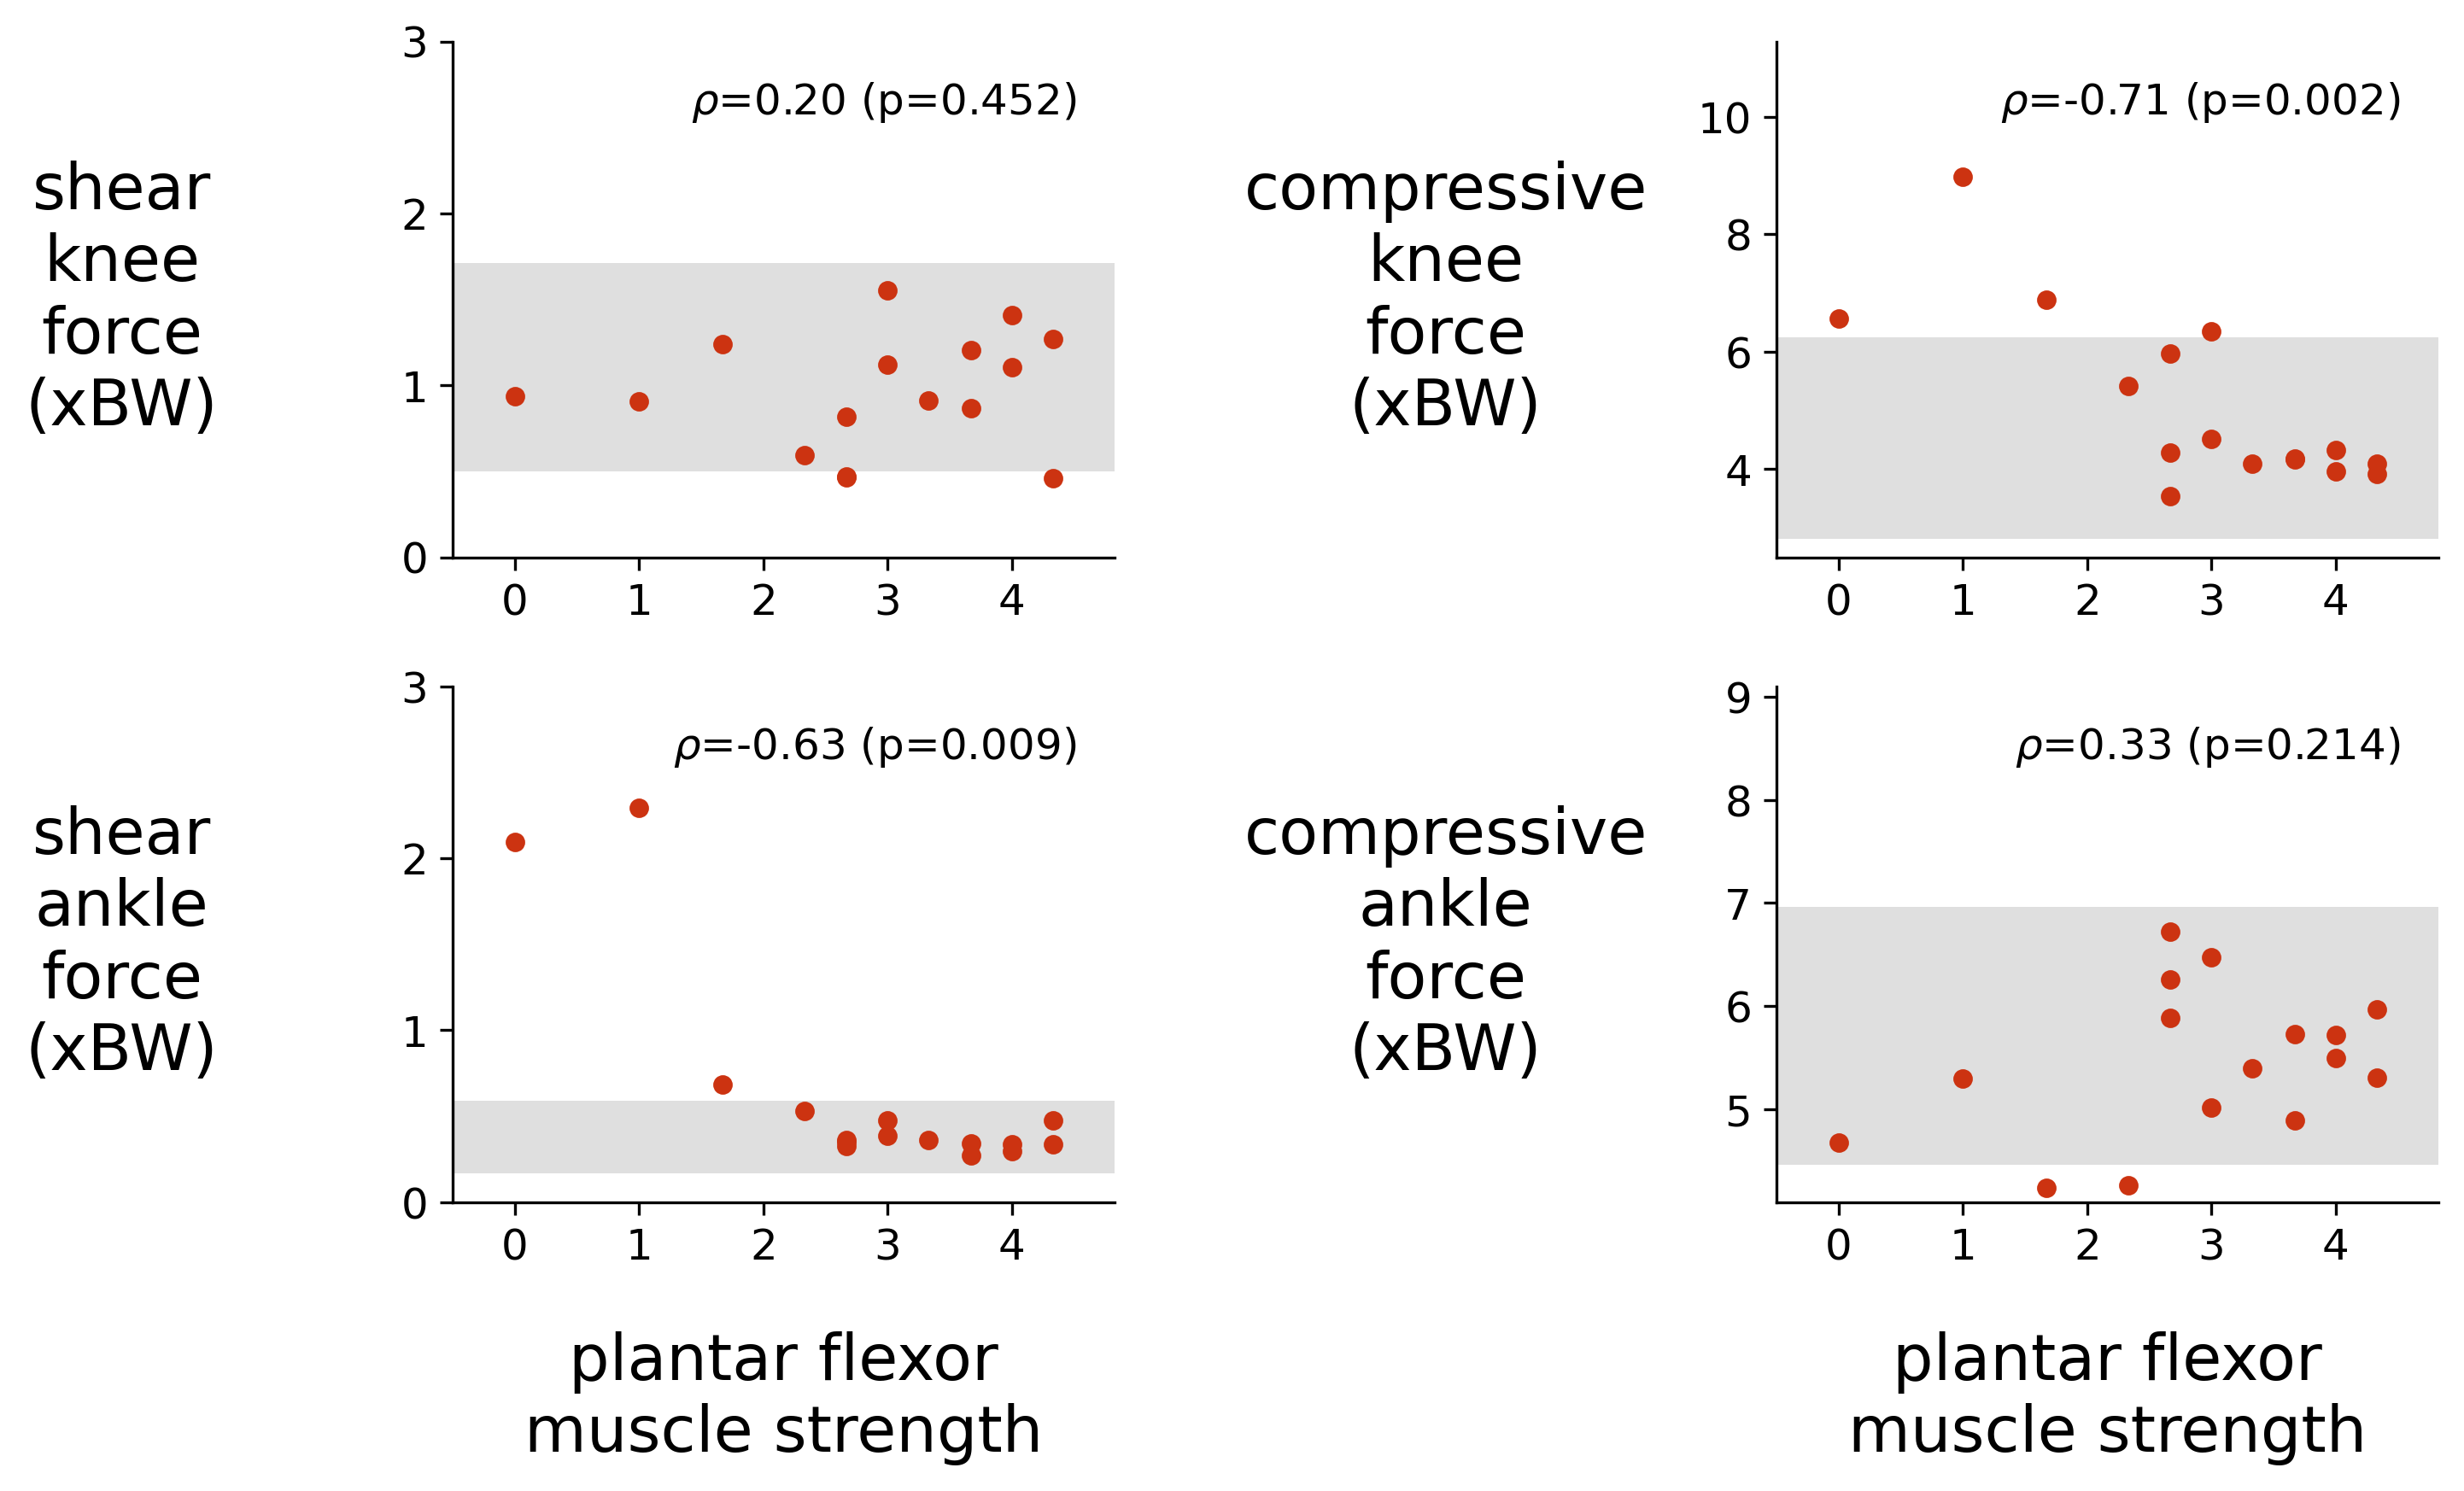

In [24]:
force_dict = {'walker_knee_on_tibia_in_tibia_shear_peak': 'shear\nknee\nforce',
              'walker_knee_on_tibia_in_tibia_fy_peak': 'compressive\nknee\nforce',
              'ankle_on_tibia_in_tibia_shear_peak': 'shear\nankle\nforce',
              'ankle_on_tibia_in_tibia_fy_peak': 'compressive\nankle\nforce'}

f, axes = plt.subplots(2, 2, dpi=300)
force_names = list(force_dict.keys())
for i in range(len(force_names)):
    plt.subplot(2,2,i+1)
    force = force_names[i]

    td_peaks = np.abs(np.divide(td_force_peaks[force],
                                9.81*td_force_peaks['bodymass']))    
    td_x = np.linspace(min(sb_force_peaks['plantar flexor strength'])-0.5,
                       max(sb_force_peaks['plantar flexor strength'])+0.5, 2)
    td_mean = np.mean(td_peaks)
    td_sd = np.std(td_peaks)
    plt.fill_between(td_x, td_mean-2*td_sd, td_mean+2*td_sd, color='gray',
                     alpha=0.25, linewidth=0)
    
    sb_peaks = np.abs(np.divide(sb_force_peaks[force],
                                9.81*sb_force_peaks['bodymass']))
    r_sb, p_sb = spearmanr(sb_force_peaks['plantar flexor strength'], sb_peaks)
    plt.scatter(sb_force_peaks['plantar flexor strength'], sb_peaks, color=COLOR_SB,
                s=20, label=r"$\rho$=%.2f (p=%.3f)" %(r_sb, p_sb))

    if i in [2, 3]:
        plt.xlabel('plantar flexor\nmuscle strength', fontsize=18)

    ylabel = force_dict[force] + '\n(xBW)'
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    
    plt.xlim([min(sb_force_peaks['plantar flexor strength'])-0.5,
              max(sb_force_peaks['plantar flexor strength'])+0.5])

    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if 'shear' in ylabel:
        _, ylim = ax.get_ylim()
        new_ylim = int(np.ceil(ylim+0.5))
        plt.ylim([0, new_ylim])
        plt.yticks(list(range(new_ylim+1)), list(range(new_ylim+1)))
    elif 'compressive' in ylabel:
        ymin, ymax = ax.get_ylim()
        plt.ylim([ymin, ymax+2])
    
    leg = plt.legend(handlelength=0, handletextpad=0, frameon=False, fontsize=12)
    for item in leg.legendHandles:
        item.set_visible(False)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

f.set_figheight(6)
f.set_figwidth(10)
plt.subplots_adjust(wspace=1, hspace=0.25)
plt.savefig('../postprocessing/figures/pf_strength.jpeg', bbox_inches='tight')

Plantar flexor muscle strength was negatively correlated with compressive knee force ($\rho$ = -0.71, p = 0.002) and shear ankle force ($\rho$ = -0.63, p=0.009) in the group with spina bifida. The three participants with the lowest plantar flexor muscle strength exhibited peak compressive knee forces and peak shear ankle forces greater than those exhibited by participants with typical development (mean $\pm$ two standard deviations).

Correlations excluding these three participants were not significant:

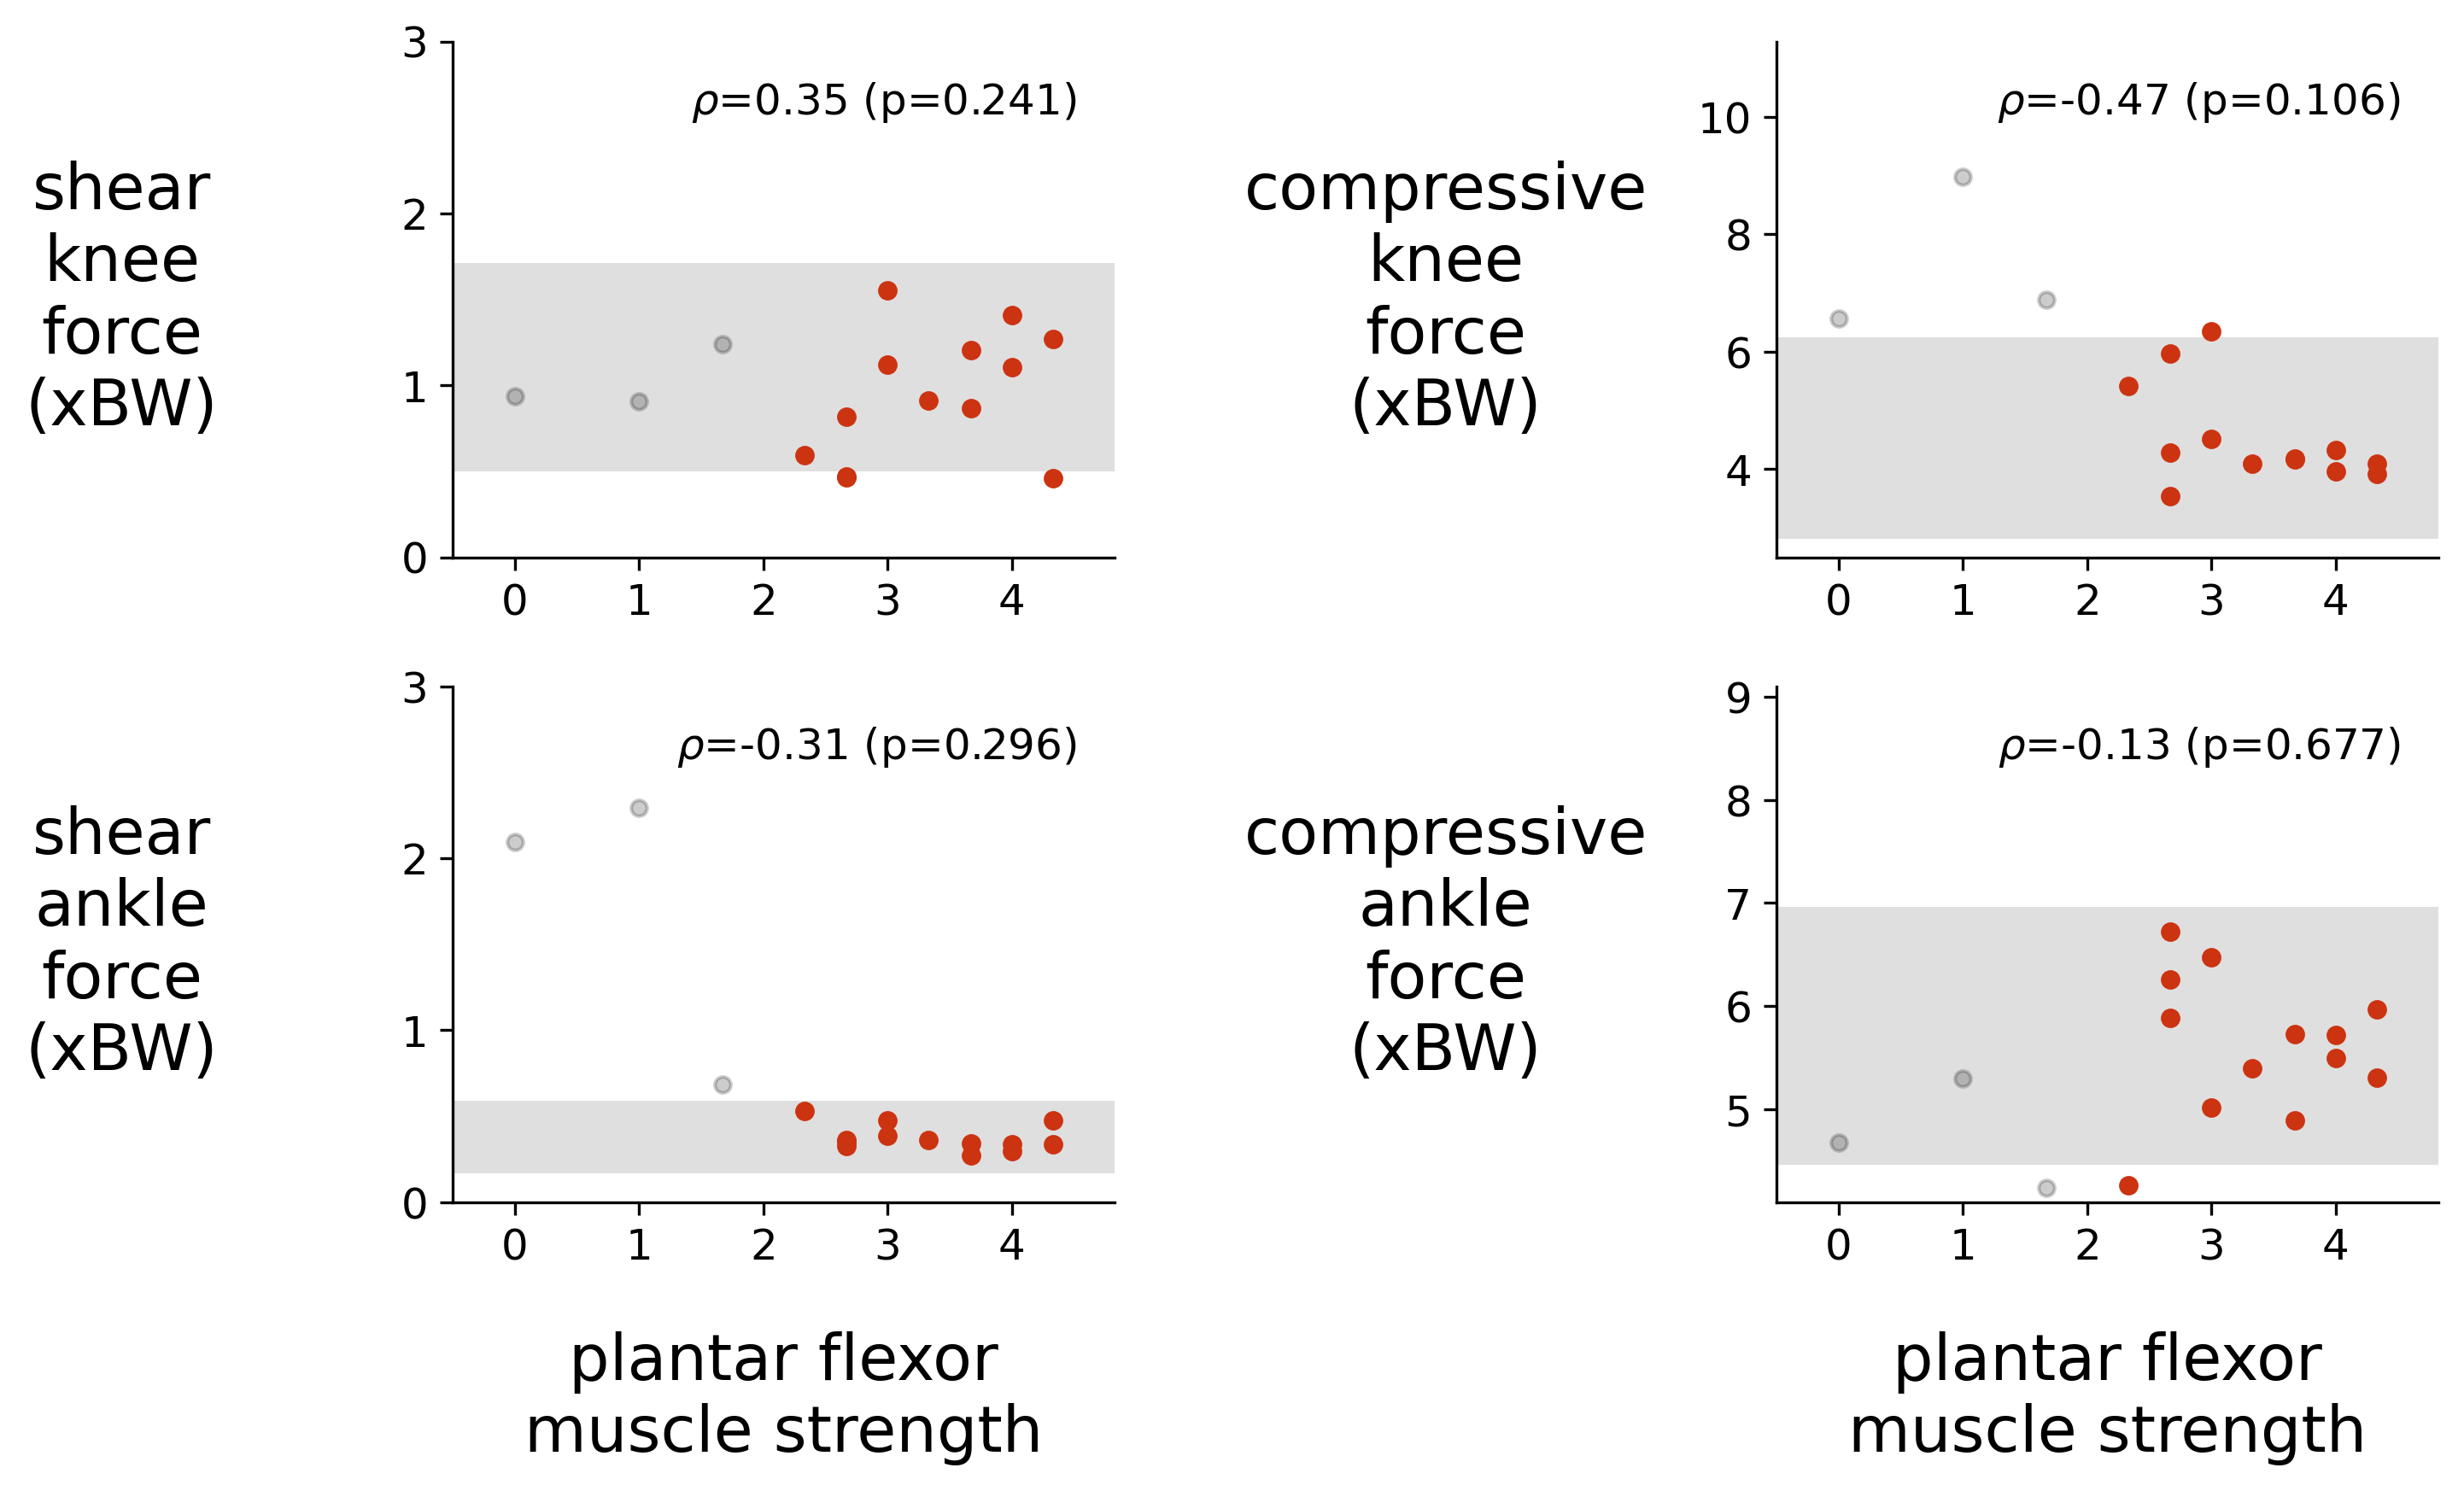

In [25]:
WEAK_THRESHOLD = 2

sb_no_weak = sb_force_peaks[sb_force_peaks['plantar flexor strength'] > WEAK_THRESHOLD]
sb_weak_only = sb_force_peaks[sb_force_peaks['plantar flexor strength'] < WEAK_THRESHOLD]

force_dict = {'walker_knee_on_tibia_in_tibia_shear_peak': 'shear\nknee\nforce',
              'walker_knee_on_tibia_in_tibia_fy_peak': 'compressive\nknee\nforce',
              'ankle_on_tibia_in_tibia_shear_peak': 'shear\nankle\nforce',
              'ankle_on_tibia_in_tibia_fy_peak': 'compressive\nankle\nforce'}

f, axes = plt.subplots(2, 2, dpi=300)
force_names = list(force_dict.keys())
for i in range(len(force_names)):
    plt.subplot(2,2,i+1)
    force = force_names[i]

    td_peaks = np.abs(np.divide(td_force_peaks[force],
                                9.81*td_force_peaks['bodymass']))    
    td_x = np.linspace(min(sb_weak_only['plantar flexor strength'])-0.5,
                       max(sb_no_weak['plantar flexor strength'])+0.5, 2)
    td_mean = np.mean(td_peaks)
    td_sd = np.std(td_peaks)
    plt.fill_between(td_x, td_mean-2*td_sd, td_mean+2*td_sd, color='gray',
                     alpha=0.25, linewidth=0)
    
    sb_peaks = np.abs(np.divide(sb_no_weak[force],
                                9.81*sb_no_weak['bodymass']))
    r_sb, p_sb = spearmanr(sb_no_weak['plantar flexor strength'], sb_peaks)
    plt.scatter(sb_no_weak['plantar flexor strength'], sb_peaks, color=COLOR_SB,
                s=20, label=r"$\rho$=%.2f (p=%.3f)" %(r_sb, p_sb))
    
    # plot those not included in correlation calculation
    sb_weak_peaks = np.abs(np.divide(sb_weak_only[force],
                                9.81*sb_weak_only['bodymass']))
    plt.scatter(sb_weak_only['plantar flexor strength'], sb_weak_peaks, color='black',
                s=20, alpha=0.2)

    if i in [2, 3]:
        plt.xlabel('plantar flexor\nmuscle strength', fontsize=18)

    ylabel = force_dict[force] + '\n(xBW)'
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    
    plt.xlim([min(sb_weak_only['plantar flexor strength'])-0.5,
              max(sb_no_weak['plantar flexor strength'])+0.5])

    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.25)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if 'shear' in ylabel:
        _, ylim = ax.get_ylim()
        new_ylim = int(np.ceil(ylim+0.5))
        plt.ylim([0, new_ylim])
        plt.yticks(list(range(new_ylim+1)), list(range(new_ylim+1)))
    elif 'compressive' in ylabel:
        ymin, ymax = ax.get_ylim()
        plt.ylim([ymin, ymax+2])
    
    leg = plt.legend(handlelength=0, handletextpad=0, frameon=False, fontsize=12)
    for item in leg.legendHandles:
        item.set_visible(False)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

f.set_figheight(6)
f.set_figwidth(10)
plt.subplots_adjust(wspace=1, hspace=0.25)

# Differences between participants with weak plantar flexor muscles and the rest of the participants with spina bifida

In [26]:
COLOR_NO_WEAK = '#117733'
COLOR_WEAK = '#EE7733'

## Walking speed

In [27]:
sb_demographics_no_weak = sb_demographics[sb_demographics['plantar flexor strength'] > WEAK_THRESHOLD]
sb_demographics_weak = sb_demographics[sb_demographics['plantar flexor strength'] < WEAK_THRESHOLD]

print('t-test (note small n!)')
print_ttest(sb_demographics_no_weak, sb_demographics_weak, 'non-weak', 'weak', 'walking speed')

t-test (note small n!)
walking speed: 0.731
	non-weak: 1.1 (0.1)
	weak: 1.2 (0.1)


These three participants with the lowest plantar flexor muscle strength walked at an average speed similar to that of the rest of the group with spina bifida.

## Kinematics

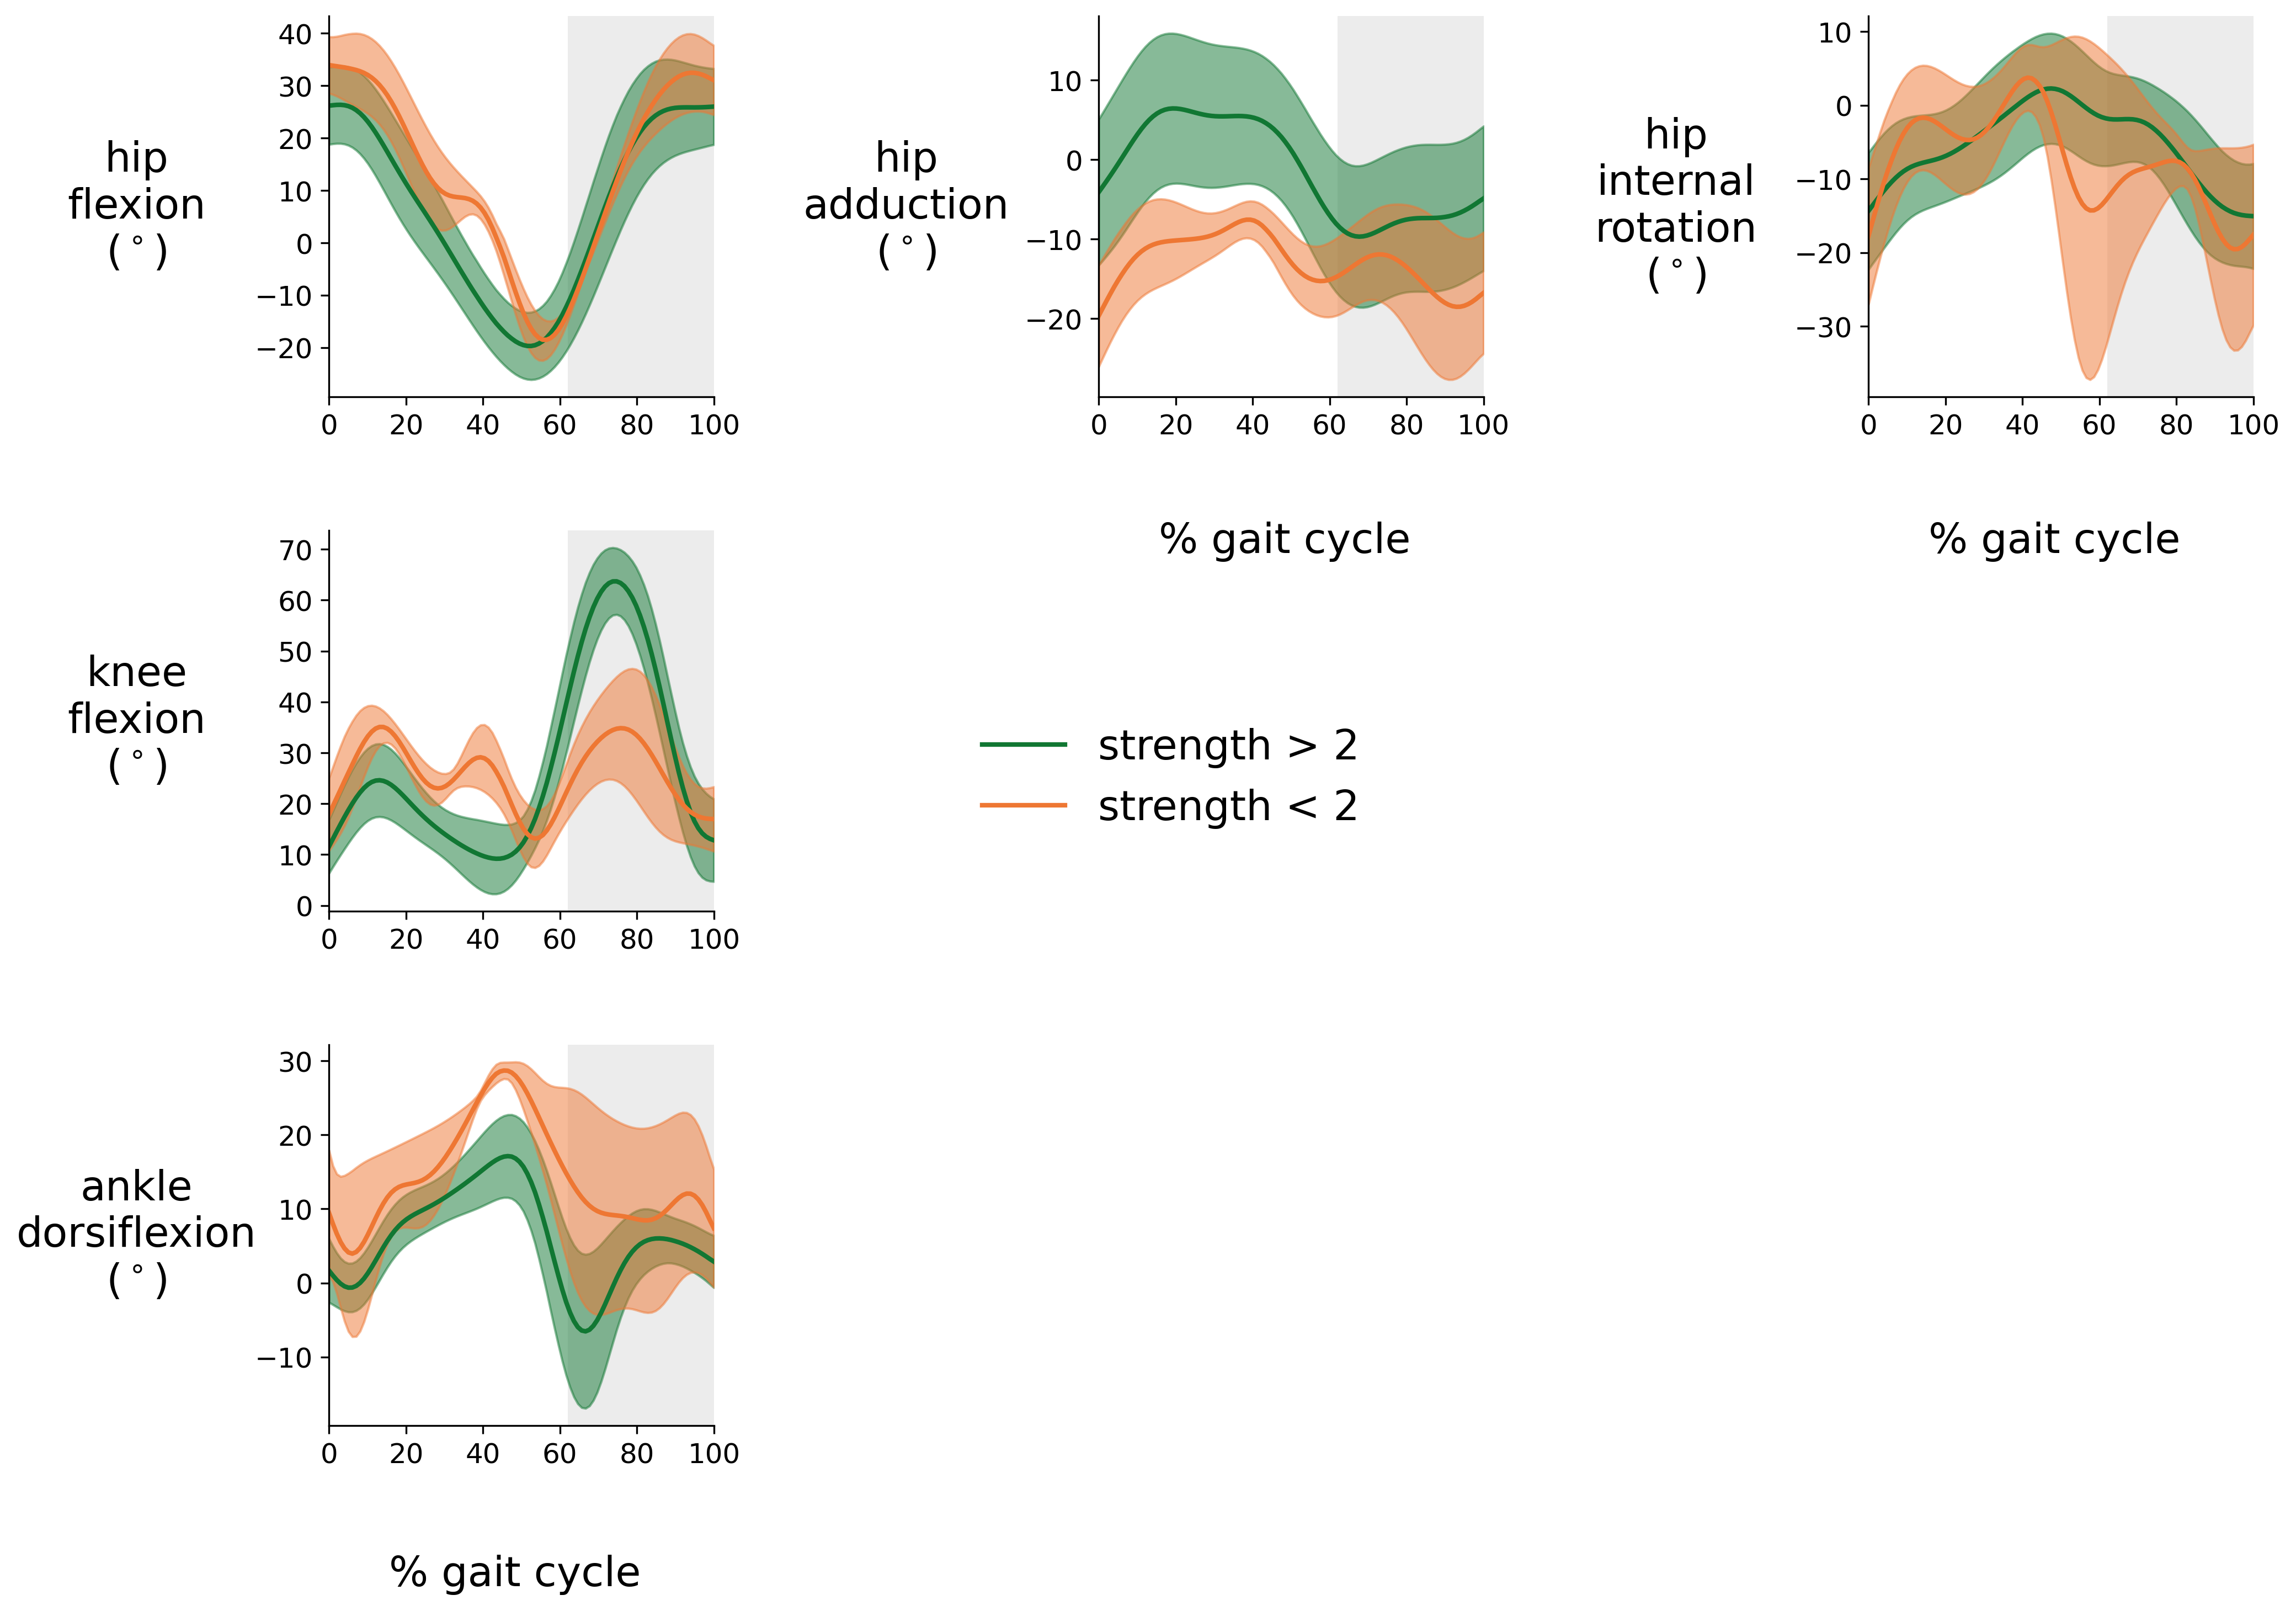

In [28]:
sb_waveforms_merged = sb_waveforms.merge(sb_demographics[['subject', 'plantar flexor strength']], on='subject')
sb_waveforms_no_weak = sb_waveforms_merged[sb_waveforms_merged['plantar flexor strength'] > WEAK_THRESHOLD]
sb_waveforms_weak = sb_waveforms_merged[sb_waveforms_merged['plantar flexor strength'] < WEAK_THRESHOLD]

f, axes = plt.subplots(6, 3, gridspec_kw={'height_ratios': [8, 1, 8, 1, 8, 1]}, dpi=300)
plot_cells = [1, 2, 3, 7, 13]
kinem_names = list(KINEM_NAME_MAP.keys())
for i in range(len(kinem_names)):
    plt.subplot(6, 3, plot_cells[i])
    waveform = kinem_names[i]
    sb_waveform_no_weak = sb_waveforms_no_weak[waveform]
    sb_waveform_weak = sb_waveforms_weak[waveform]
    
    td_data = np.stack(td_waveform.to_numpy())
    sb_data = np.stack(sb_waveform.to_numpy())
    sb_data_no_weak = np.stack(sb_waveform_no_weak.to_numpy())
    sb_data_weak = np.stack(sb_waveform_weak.to_numpy())
    
    ylabel = KINEM_NAME_MAP[waveform][:-6]
    
    ti = run_spm(sb_data_no_weak, sb_data_weak, waveform, color1=COLOR_NO_WEAK, color2=COLOR_WEAK, alpha=1)

    ylabel = ylabel + ' ($^\circ$)'
    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0,100])
    
    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.5, 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # plot swing
    ymin, ymax = ax.get_ylim()
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    ax.set_ylim((ymin, ymax))

for i in [4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]:
    fig = plt.subplot(6, 3, i)
    plt.box(False)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

f.text(0.2, 0.09, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.51, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)
f.text(0.82, 0.61, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(12)
f.set_figwidth(15)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_NO_WEAK)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_WEAK)
plt.legend([td_line, sb_line], [f'strength > {WEAK_THRESHOLD}',
                                f'strength < {WEAK_THRESHOLD}'],
           loc='center left', fontsize=18, bbox_to_anchor=(-2.4, 15, 1, 1),
           frameon=False)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/kinematics_sb.jpeg', bbox_inches='tight')

These three participants with the lowest plantar flexor muscle strength walked with more hip flexion and knee flexion during stance, less knee flexion during swing, and more hip abduction and ankle dorsiflexion throughout the gait cycle.

## Ankle power

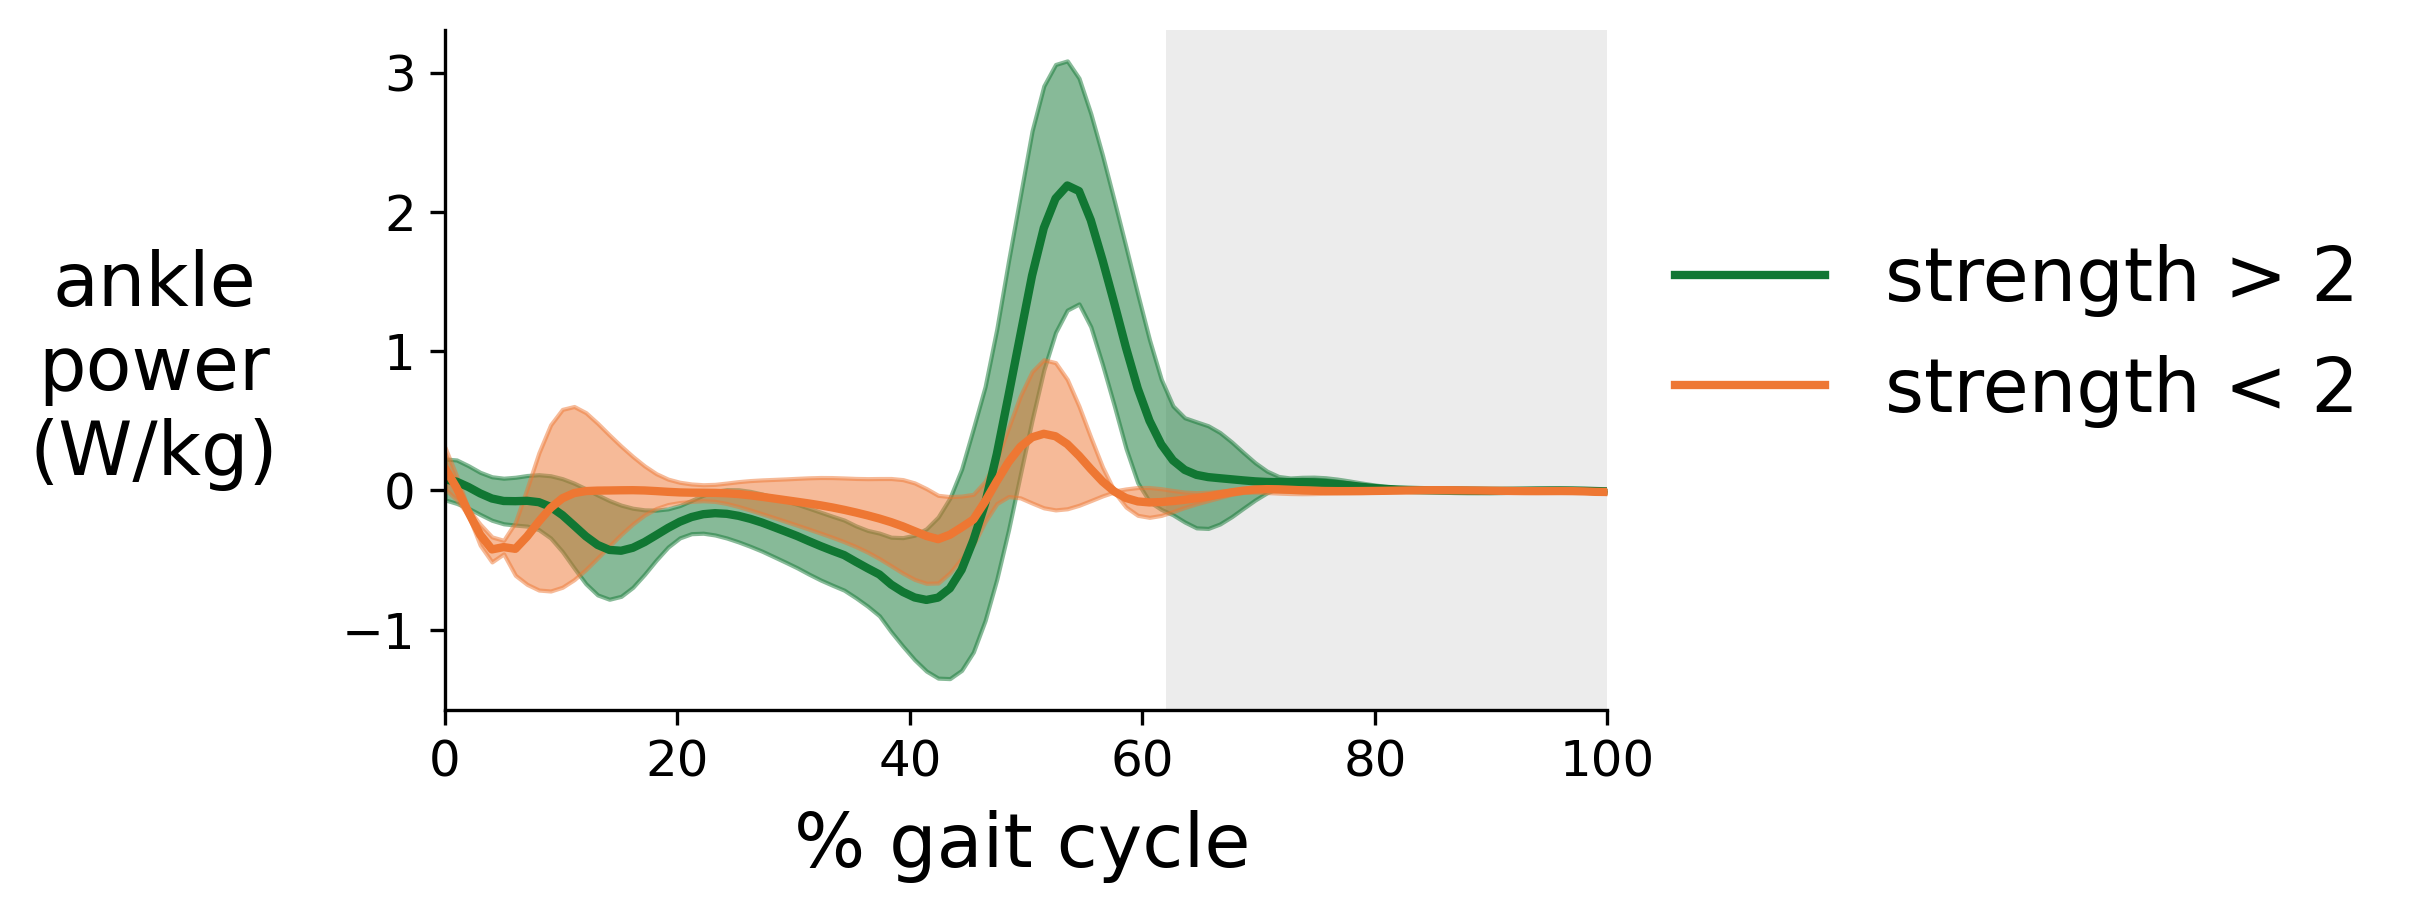

In [29]:
waveform = 'ankle_angle_power'
ylabel = 'ankle power (W/kg)'

sb_waveform_no_weak = sb_waveforms_no_weak[waveform]
sb_waveform_weak = sb_waveforms_weak[waveform]

sb_data_no_weak = np.stack(np.divide(sb_waveform_no_weak, sb_waveforms_no_weak['bodymass']))
sb_data_weak = np.stack(np.divide(sb_waveform_weak, sb_waveforms_weak['bodymass']))

f, axes = plt.subplots(dpi=300)
ti = run_spm(sb_data_no_weak, sb_data_weak, waveform, color1=COLOR_NO_WEAK, color2=COLOR_WEAK, alpha=1)
ylabel = ylabel.replace(' ', '\n')
plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,100])

ax = plt.gca()
ax.yaxis.set_label_coords(-0.25, 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plot swing
ymin, ymax = ax.get_ylim()
plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                 linewidth=0, zorder=0)
ax.set_ylim((ymin, ymax))

f.text(0.51, -0.05, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(3)
f.set_figwidth(5)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_NO_WEAK)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_WEAK)
plt.legend([td_line, sb_line], [f'strength > {WEAK_THRESHOLD}',
                                f'strength < {WEAK_THRESHOLD}'],
           loc='center left', fontsize=18, bbox_to_anchor=(1, 0.05, 1, 1),
           frameon=False)
plt.subplots_adjust(wspace=1)

Ankle power in the group of three participants with the lowest plantar flexor muscle strength was low.

## Muscle group forces

In [32]:
len(sb_waveforms_no_weak)

13

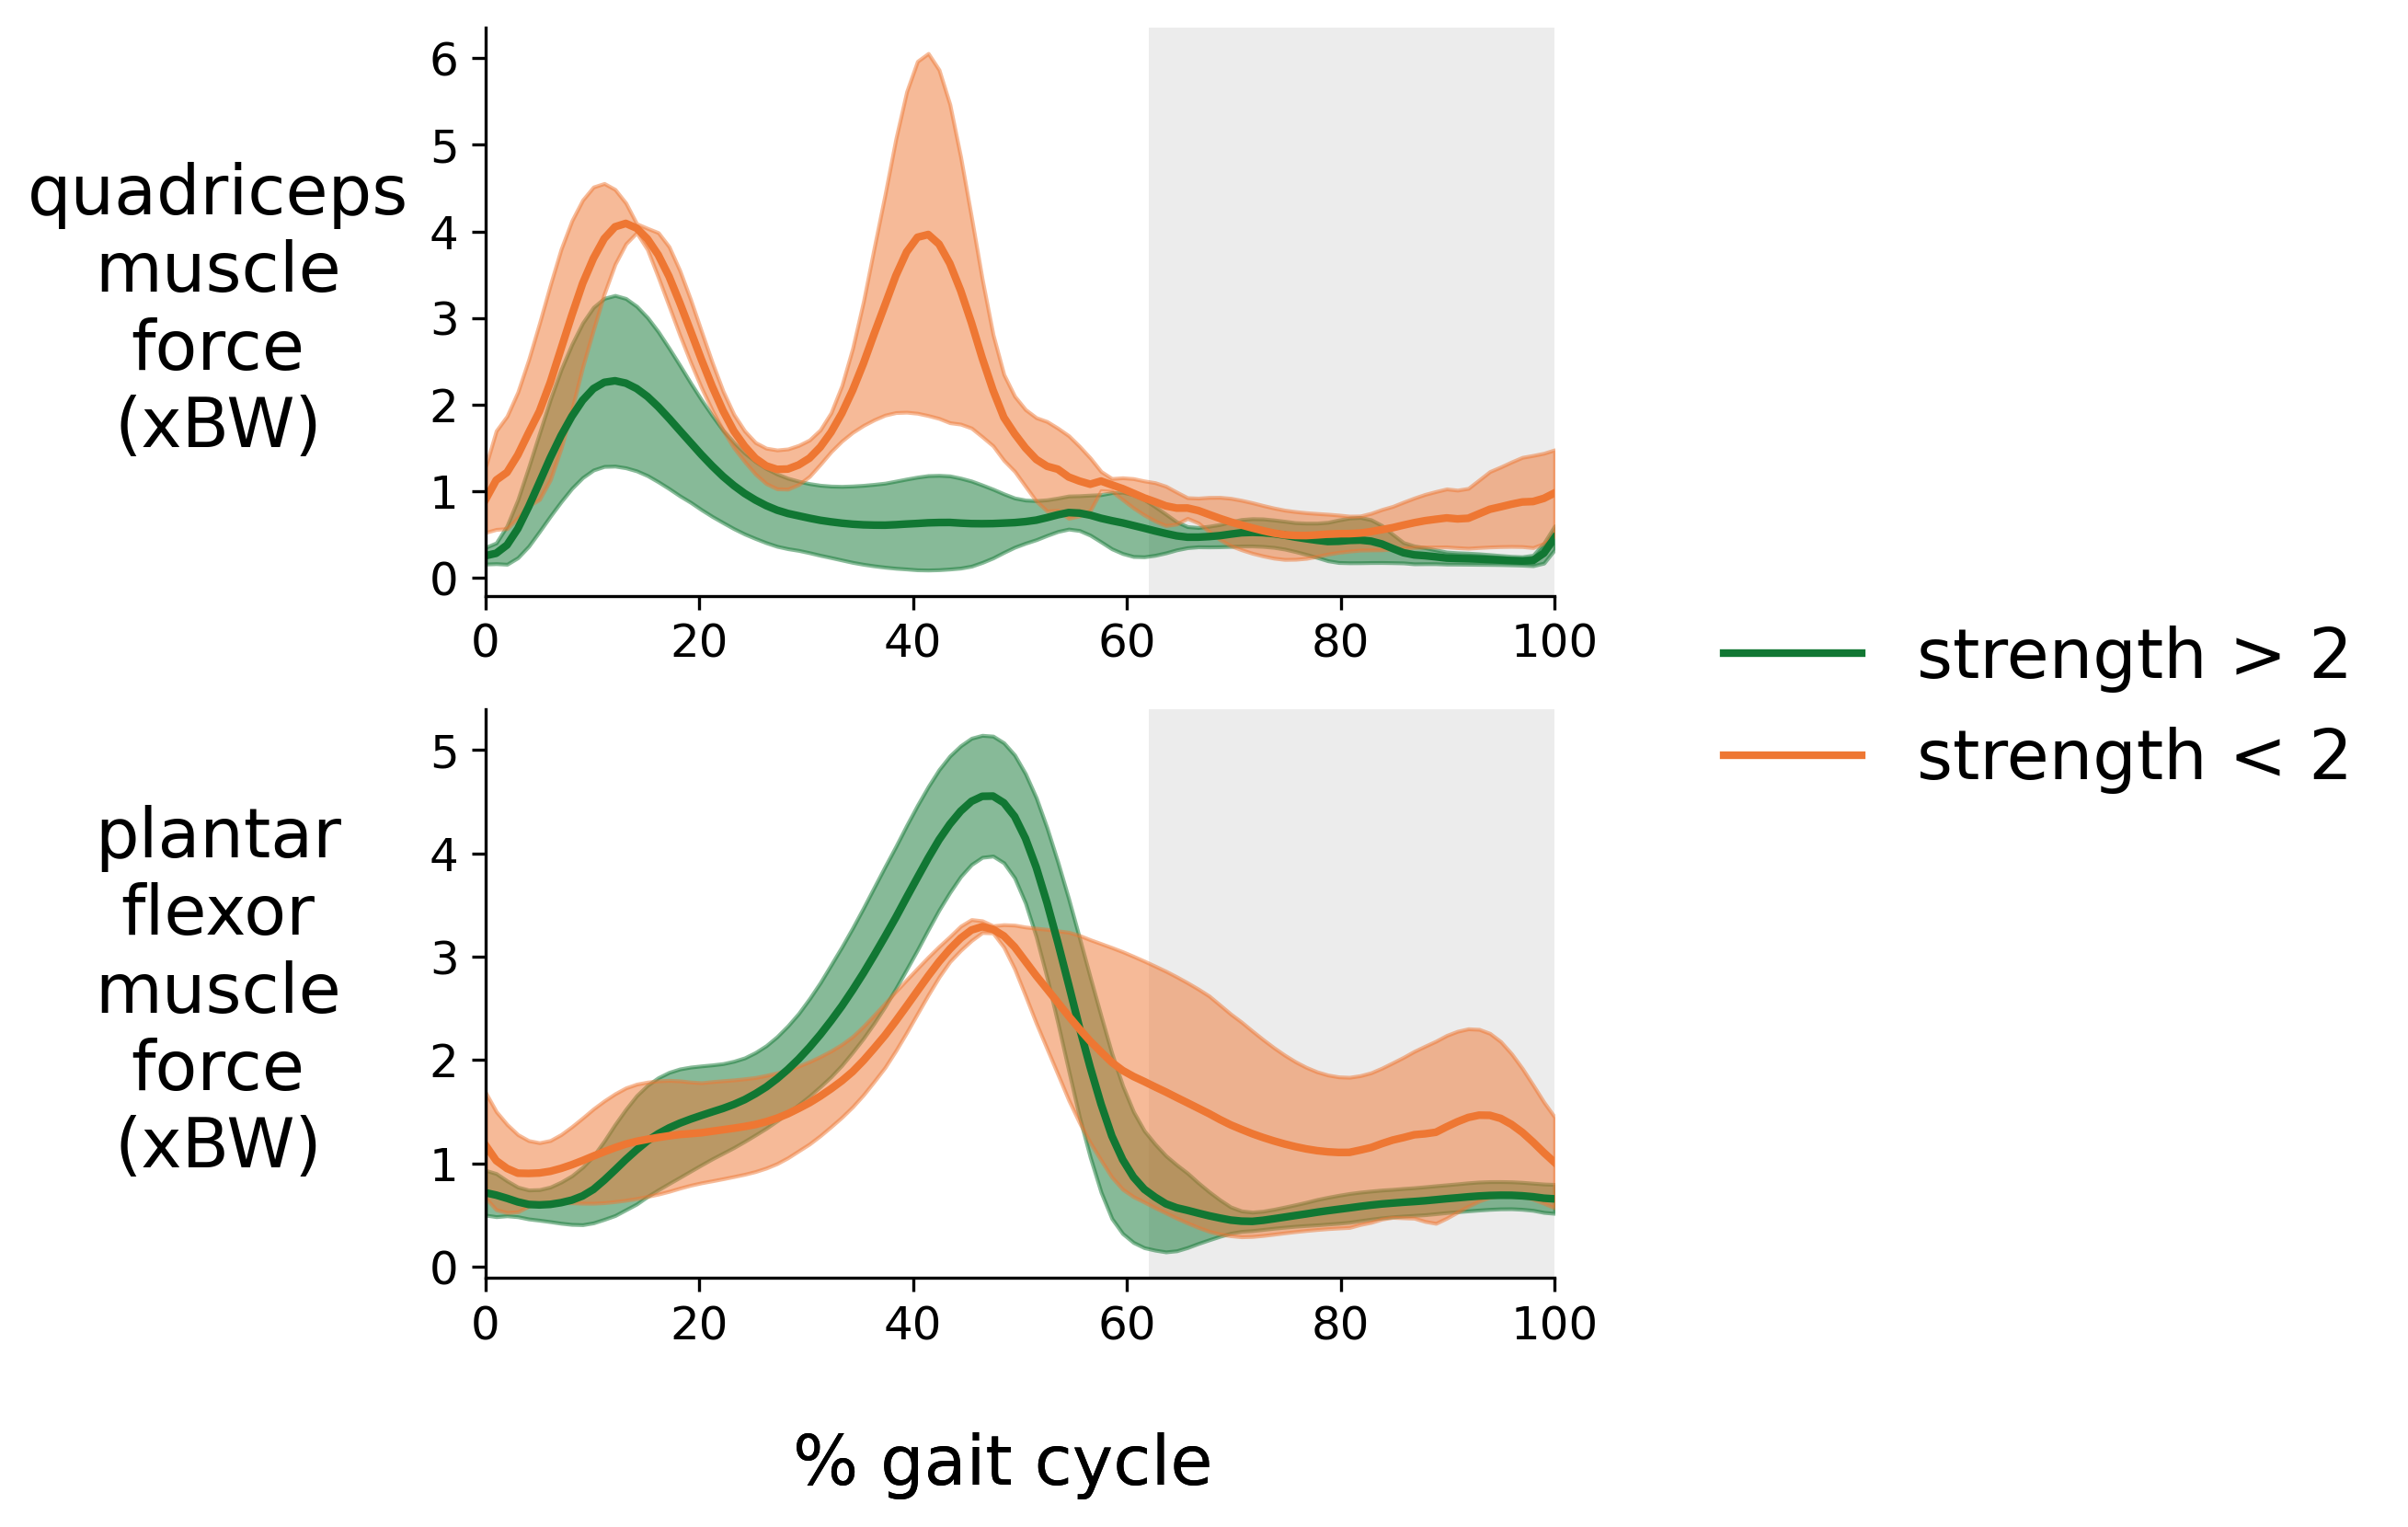

In [34]:
f, ax = plt.subplots(2,1,dpi=300)
muscles = {'quadriceps': ['recfem', 'vaslat', 'vasint', 'vasmed'],
           'plantar flexor': ['gaslat', 'gasmed', 'soleus', 'fhl', 'fdl', 'perbrev', 'perlong', 'tibpost']}

muscle_groups = list(muscles.keys())
for i in range(len(muscle_groups)):
    plt.subplot(2, 1, i+1)
    muscle_group_name = muscle_groups[i]
    muscle_group_muscles = muscles[muscle_group_name]
    
    total_waveforms_no_weak = np.zeros((len(sb_waveforms_no_weak),100))
    total_waveforms_weak = np.zeros((len(sb_waveforms_weak),100))
    
    for waveform in muscle_group_muscles:
        sb_waveform_no_weak = sb_waveforms_no_weak[waveform]
        sb_data_no_weak = np.stack(np.divide(sb_waveform_no_weak.to_numpy(), sb_waveforms_no_weak['bodymass']*9.81))
        total_waveforms_no_weak += sb_data_no_weak

        sb_waveform_weak = sb_waveforms_weak[waveform]
        sb_data_weak = np.stack(np.divide(sb_waveform_weak.to_numpy(), sb_waveforms_weak['bodymass']*9.81))
        total_waveforms_weak += sb_data_weak

    sb_data_no_weak_mean = np.mean(total_waveforms_no_weak, axis=0)
    sb_data_no_weak_std = np.std(total_waveforms_no_weak, axis=0)

    sb_data_weak_mean = np.mean(total_waveforms_weak, axis=0)
    sb_data_weak_std = np.std(total_waveforms_weak, axis=0)

    ylabel = f'{muscle_group_name} muscle force (xBW)'
    
    # plot mean curves
    plt.fill_between(np.linspace(0,100,100), sb_data_no_weak_mean-sb_data_no_weak_std, 
                     sb_data_no_weak_mean+sb_data_no_weak_std,
                     color=COLOR_NO_WEAK, alpha=0.5)
    plt.fill_between(np.linspace(0,100,100), sb_data_weak_mean-sb_data_weak_std,
                     sb_data_weak_mean+sb_data_weak_std,
                     color=COLOR_WEAK, alpha=0.5)

    # mean waveforms
    plt.plot(np.linspace(0,100,100), sb_data_no_weak_mean, COLOR_NO_WEAK, linewidth=2)
    plt.plot(np.linspace(0,100,100), sb_data_weak_mean, COLOR_WEAK, linewidth=2)

    ylabel = ylabel.replace(' ', '\n')
    plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
    plt.xticks(np.linspace(0,100,6), [0, 20, 40, 60, 80, 100], fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([0,100])

    ax = plt.gca()
    ax.yaxis.set_label_coords(-0.25, 0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # plot swing
    ymin, ymax = ax.get_ylim()
    plt.fill_between(np.arange(62,101), ymin, ymax, color='gray', alpha=0.15,
                     linewidth=0, zorder=0)
    ax.set_ylim((ymin, ymax))

    f.text(0.5, 0, '% gait cycle', horizontalalignment='center', fontsize=18)

f.set_figheight(6)
f.set_figwidth(5)
td_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_NO_WEAK)
sb_line = Line2D([0,1],[0,1], linestyle='-', linewidth=2, color=COLOR_WEAK)
plt.legend([td_line, sb_line], [f'strength > {WEAK_THRESHOLD}',
                                f'strength < {WEAK_THRESHOLD}'],
           loc='center left', fontsize=18, bbox_to_anchor=(1.1, 0.5, 1, 1),
           frameon=False,)
plt.subplots_adjust(wspace=1)
plt.savefig('../postprocessing/figures/muscle_forces_sb.jpeg', bbox_inches='tight')

The increased compressive knee forces in the three participants with the weakest plantar flexor muscles may reflect increased activations of the quadriceps muscles.

# Dynamic plantar flexor force vs manual muscle test score

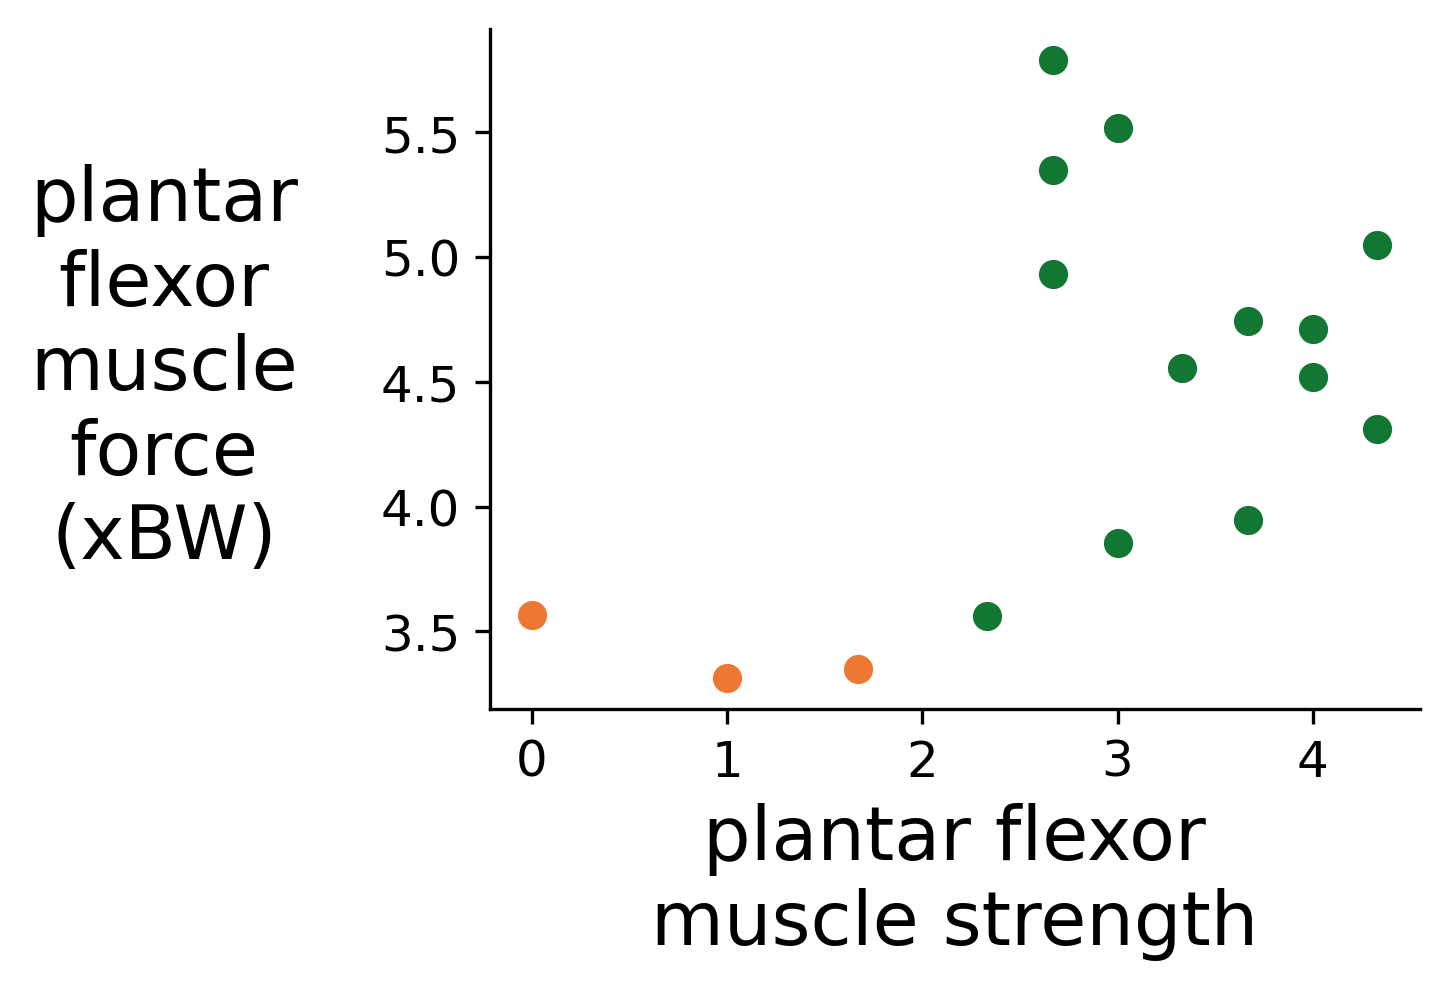

In [35]:
sb_no_weak_pf_force_peaks = np.max(total_waveforms_no_weak, axis=1)
sb_weak_pf_force_peaks = np.max(total_waveforms_weak, axis=1)

f, axes = plt.subplots(dpi=300)
plt.scatter(sb_waveforms_no_weak['plantar flexor strength'], sb_no_weak_pf_force_peaks, color=COLOR_NO_WEAK)
plt.scatter(sb_waveforms_weak['plantar flexor strength'], sb_weak_pf_force_peaks, color=COLOR_WEAK)
plt.xlabel('plantar flexor\nmuscle strength', fontsize=18)
plt.ylabel('plantar\nflexor\nmuscle\nforce\n(xBW)')
plt.ylabel(ylabel, fontsize=18, rotation=0, verticalalignment='center')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax = plt.gca()
ax.yaxis.set_label_coords(-0.35, 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.set_figheight(3)
f.set_figwidth(4)

spearmanr(list(sb_waveforms_no_weak['plantar flexor strength']) + list(sb_waveforms_weak['plantar flexor strength']),
                       list(sb_no_weak_pf_force_peaks) + list(sb_weak_pf_force_peaks)
                      )
plt.savefig('../postprocessing/figures/dynamic_vs_static_pf_strength.jpeg', bbox_inches='tight')

Manual muscle testing may underestimate the dynamic force capacity of plantar flexor muscles ([Kainz 2018](https://doi.org/10.1016/j.gaitpost.2018.07.172)). Above, we find that simulated activations of the plantar flexor muscles generally aligned with manual muscle test scores. In particular, participants with the lowest manual muscle test scores exhibited low peak dynamic plantar flexor forces.

# Plantar flexor strength vs bone strength

## Using raw values

In [36]:
# merge pf strength and bone property dataframes
sb_bone_pfstrength = sb_bone_outcomes.merge(sb_demographics, on=['subject'])

In [37]:
for bone_outcome_name in bone_outcome_names:
    x = sb_bone_pfstrength['plantar flexor strength']
    y = sb_bone_pfstrength[bone_outcome_name]
    
    r, p = spearmanr(x, y)
    print('rho = %.2f (p = %.3f)' %(r, p))
#     plt.scatter(x, y)
#     plt.title(bone_outcome_name)
#     plt.show()

rho = -0.13 (p = 0.627)
rho = 0.15 (p = 0.588)
rho = -0.16 (p = 0.562)
rho = -0.08 (p = 0.760)
rho = 0.02 (p = 0.944)
rho = -0.09 (p = 0.735)
rho = 0.10 (p = 0.703)
rho = -0.01 (p = 0.974)


## Using unit-normalized values

In [38]:
for bone_outcome_name in bone_outcome_names:
    x = sb_bone_pfstrength['plantar flexor strength']    
    y = sb_bone_pfstrength[bone_outcome_name].to_numpy()
    
    if '(mm)' in bone_outcome_name:
        height = sb_bone_pfstrength['height (cm)'].to_numpy()
        y = y / height
    elif '(mm2)' in bone_outcome_name:
        height = sb_bone_pfstrength['height (cm)'].to_numpy()
        y = y / height**2
    elif '(mg/cm3)' in bone_outcome_name:
        height = sb_bone_pfstrength['height (cm)'].to_numpy()
        mass = sb_bone_pfstrength['weight (kg)'].to_numpy()
        y = y / (mass / height**3)
    
    r, p = spearmanr(x, y)
    print('rho = %.2f (p = %.3f)' %(r, p))
#     plt.scatter(x, y)
#     plt.title(bone_outcome_name)
#     plt.show()

rho = -0.19 (p = 0.479)
rho = 0.06 (p = 0.836)
rho = -0.07 (p = 0.802)
rho = -0.16 (p = 0.543)
rho = -0.07 (p = 0.802)
rho = -0.09 (p = 0.731)
rho = 0.26 (p = 0.327)
rho = -0.08 (p = 0.760)


Plantar flexor muscle strength was not correlated with bone outcomes in the group with spina bifida.